<span style="font-family:Lucida Sans;font-size:22px">Respondents in the Kaggle Survey come from around the world but the distribution is not uniform. What could be the reasons for this? Finding the reasons for low participation from some countries will give insights to decide on the help required. Looking into the profiles of respondents will help understand the groups that need encouragement. What can Kaggle community do to encourage more involvement from countries and groups with fewer participation?</span>

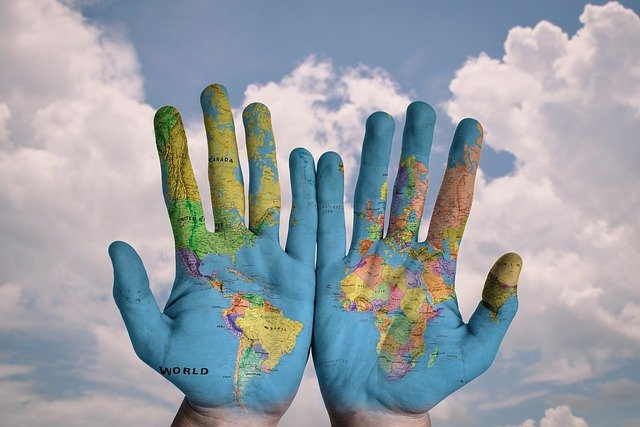

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Import Libraries

from sklearn.preprocessing import minmax_scale
import copy

from plotly.offline import init_notebook_mode, iplot
from plotly import subplots
import plotly.figure_factory as ff
import plotly as py
import plotly.express as px
import plotly.graph_objects as go
init_notebook_mode(connected=True)

In [ ]:
# Define standard colors
# https://visme.co/blog/color-combinations/

# color scheme 1 - Bright
color_red = '#D50B53'
color_white = '#F4F3F4'
color_verylightpurple = '#D8BFD8'
color_lightpurple = '#A882C1'
color_darkpurple = '#824CA7'
color_yellow = '#B9C406'

# color scheme 2 - blue gray dark
color_gray = '#6C6B74'
color_darkgray = '#2E303E'
color_blue = '#9199BE'
color_darkblue = '#54678F'
color_black = '#212624'

# color scheme 3 - berry colors
color_lightred1 = '#EE6C81'
color_lightred2 = '#F092A5'
color_red2 = '#BB1924'
color_bluegraylight = '#AFBADC'
color_bluegray = '#777CA8'

color_greengray = '#6A8A82'

# Plots customization
# font = "Droid Serif"
font = 'Arial'

In [ ]:
# DATA IMPORT AND PREPROCESSING
# Import all the databases. Many public databases are being used in this analysis

# Kaggle Survey data 2021
kaggle_survey_df = pd.read_csv('../input/kaggle-survey-2021/kaggle_survey_2021_responses.csv',
                              usecols=['Q1','Q2','Q3', 'Q4', 'Q5', 'Q6', 'Q7_Part_1', 'Q7_Part_2', 'Q7_Part_12'])
kaggle_survey_df = kaggle_survey_df.iloc[1:,:] # The first row was describing the columns

# Renaming name of countries that are too long
# This is only for the purpose of cleaning up the plots. No offense intended.
country_short = {"United States of America": "USA", "United Arab Emirates": "UAE",
                 "United Kingdom of Great Britain and Northern Ireland":"UK",
     "I do not wish to disclose my location":"Undisclosed",
                 "Iran, Islamic Republic of...":"Iran", "Hong Kong (S.A.R.)":"Hong Kong"}
kaggle_survey_df["Q3"] = kaggle_survey_df["Q3"].map(country_short).fillna(kaggle_survey_df["Q3"]) # 'Q3' has the country data

# At the moment 'Nonbinary' gender category is not being included in this analysis
# This is the only reason to map this category as 'Undisclosed'. No offense intended.
gender_short = {"Nonbinary":"Undisclosed","Prefer not to say":"Undisclosed","Prefer to self-describe":"Undisclosed"}
kaggle_survey_df["Q2"] = kaggle_survey_df["Q2"].map(gender_short).fillna(kaggle_survey_df["Q2"]) # 'Q2' has the gender data



# StackOverflow Developer Survey 2021
stackOverflow = pd.read_csv("../input/stack-overflow-developer-survey-results-2021/survey_results_public.csv",
                           usecols = ["MainBranch", "Employment", "Country", "EdLevel", "Age", "DevType", "Gender"])

# Rename all the country names in stack overflow dataset so it will match/correspond to the Kaggle survey dataset
# (Some of the country names were shortened in Kaggle dataset for convenience, so have to make those changes here as well)
country_short = {"United States of America": "USA", "United Arab Emirates": "UAE","United Kingdom of Great Britain and Northern Ireland":"UK",
                 "Iran, Islamic Republic of...":"Iran", "Hong Kong (S.A.R.)":"Hong Kong", "Russian Federation":"Russia",
                "Venezuela, Bolivarian Republic of...":"Venezuela", "Republic of Korea":"South Korea",
                "Libyan Arab Jamahiriya": "Libya", "The former Yugoslav Republic of Macedonia":"FYR Macedonia",
                "United Republic of Tanzania":"Tanzania", "Central African Republic":"CAR","Democratic Republic of the Congo":"Congo",
                "Syrian Arab Republic":"Syria"}

stackOverflow["Country"] = stackOverflow["Country"].map(country_short).fillna(stackOverflow["Country"])

        
so_total_participants = stackOverflow.shape[0]
print("Total number of participants in StackOverflow Developer survey = ", so_total_participants)
print("Participants come from %d countries" %len(stackOverflow["Country"].unique()))

# Get only the data science professionals from StackOverflow Survey
# Used the response to question "DevType" and extract only the resposes that included any of the data science related keywords
def is_data_professionals(response_row):
    """
    Function to determine if any of the data science keywords 
    are present (in each row corresponding to column "DevType")
    """
    if isinstance(response_row, str):
        prof_keywords = ["Data", "Machine", "machine", "Database", "database", "Analyst", "analyst", "Statistician", 
                     "Engineer, data", "Data or business analyst", "Database administrator"]
        set_prof_keywords = set(prof_keywords)

        if len(list(set(response_row.split()) & set_prof_keywords)) > 0:
            return True
        else:
            return False
    else:
        return False
    
# get only responses from data science professionals
# (so - short for StackOverflow)
so_dataProfessionals = stackOverflow.loc[stackOverflow["DevType"].apply(is_data_professionals) ==True]



# 2021 World Population Dataset
world_popu_df = pd.read_csv("/kaggle/input/d/rsrishav/world-population/2021_population.csv",usecols=['country','2021_last_updated','world_%'])

# Some renaming and typecating
# Reference : https://www.kaggle.com/carriech/2021-world-population-using-plotly
world_popu_df = world_popu_df.rename(columns = {'world_%':'population_pct','2021_last_updated':'population'})
world_popu_df.replace(',','',regex = True, inplace = True)
world_popu_df['population'] = world_popu_df['population'].astype(np.int64)

world_popu_df['population_pct'] = world_popu_df['population_pct'].str.strip('%')
world_popu_df['population_pct'] = world_popu_df['population_pct'].astype(float)

# Change the country names so they will match with the Kaggle dataframe
country_short = {"United States": "USA", "United Arab Emirates": "UAE","United Kingdom":"UK","Vietnam":"Viet Nam"}
world_popu_df["country"] = world_popu_df["country"].map(country_short).fillna(world_popu_df["country"])



# Human Development Index (HDI)
hdi = pd.read_csv('/kaggle/input/human-development-index-hdi/HDI.csv', usecols = ["HDI Rank", "Country","2019"], nrows=189, encoding = 'unicode_escape')

# Based on the categorization given in - http://hdr.undp.org/en/indicators/138806 
# classify the countries based on their davelopment
hdi.loc[hdi["2019"] >= 0.800, "HDI status"] = "Very high"
hdi.loc[(hdi["2019"] >= 0.700) & (hdi["2019"] < 0.800), "HDI status"] = "High"
hdi.loc[(hdi["2019"] >= 0.550) & (hdi["2019"] < 0.700), "HDI status"] = "Medium"
hdi.loc[hdi["2019"] < 0.550, "HDI status"] = "Low"

hdi.sort_values(by="HDI Rank", inplace=True)

# Rename country names to macth Kaggle dataset
country_short = {"United States": "USA", "United Arab Emirates": "UAE","United Kingdom":"UK","Vietnam":"Viet Nam", "Hong Kong, China (SAR)":"Hong Kong",
                "Russian Federation":"Russia", "Korea (Republic of)":"South Korea", "Iran (Islamic Republic of)":"Iran", "Czechia":"Czech Republic"}
hdi["Country"] = hdi["Country"].map(country_short).fillna(hdi["Country"])

# Tertiary Education - Share of the population with tertiary education
higher_edu = pd.read_csv('../input/tertiary-education/share-of-the-population-with-completed-tertiary-education.csv')

# create a new dataframe from 'higher_edu' dataset
tertiary_education = pd.DataFrame(columns=["country", "code", "year", "ter_edu_share"])
k = 0

all_countries = higher_edu["Entity"].unique()
for i in range(len(all_countries)):
    
    # another dataframe for convinience :)
    country_section = higher_edu.loc[higher_edu["Entity"] == all_countries[i]]
    
    # get only the latest year education rate
    country_section.sort_values(by="Year", ascending=False, inplace=True)
    country_section.reset_index(inplace=True, drop=True)
    
    tertiary_education.loc[k, "country"] = all_countries[i]
    tertiary_education.loc[k, "code"] = country_section.loc[0, "Code"]
    tertiary_education.loc[k, "year"] = country_section.loc[0, "Year"]
    tertiary_education.loc[k, "ter_edu_share"] = country_section.loc[0, "Barro-Lee: Percentage of population age 15+ with tertiary schooling. Completed Tertiary"]
    
    k = k + 1
    
# rename country names to match Kaggle participant count dataframe
country_short = {"United States": "USA", "United Arab Emirates": "UAE","United Kingdom":"UK","Vietnam":"Viet Nam", 
                "Czechia":"Czech Republic"}
tertiary_education["country"] = tertiary_education["country"].map(country_short).fillna(tertiary_education["country"])



# Internet Usage 
internet_individual_share = pd.read_csv('/kaggle/input/internet-usage/share-of-individuals-using-the-internet.csv')

# process and save the required columns to another dataframe
internet_usage = pd.DataFrame(columns=["country", "code", "num_users", "usage_year", "population_share", "popu_share_year"])
k = 0

all_countries = internet_individual_share["Entity"].unique()

for i in range(len(all_countries)):
    
    country_section2 = internet_individual_share.loc[internet_individual_share["Entity"] == all_countries[i]]
    
    # Get the latest internet usage rates
    country_section2.sort_values(by="Year", ascending=False, inplace=True)
    country_section2.reset_index(inplace=True, drop=True)
    
    internet_usage.loc[k, "country"] = all_countries[i]
    internet_usage.loc[k, "code"] = country_section2.loc[0, "Code"]
    internet_usage.loc[k, "popu_share_year"] = country_section2.loc[0, "Year"]
    internet_usage.loc[k, "population_share"] = country_section2.loc[0, "Individuals using the Internet (% of population)"]
    
    k = k + 1

# Rename country names
country_short = {"United States": "USA", "United Arab Emirates": "UAE","United Kingdom":"UK","Vietnam":"Viet Nam", 
                "Czechia":"Czech Republic"}
internet_usage["country"] = internet_usage["country"].map(country_short).fillna(internet_usage["country"])


<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:#F4F3F4;
           font-size:14px;
           font-family:Arial;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px"></div>
<h2 style="text-align: left;
           padding: 5px;
              color:#D50B53;
           margin-top: 0px;
            margin-bottom: 0px;">
TABLE OF CONTENTS
</h2>

    
<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:#A882C1;
           font-size:14px;
           font-family:Arial;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px">
<h2 style="text-align: left;
           padding: 5px;
              color:#F4F3F4;
           margin-top: 0px;
            margin-bottom: 0px;">
1. Introduction
</h2></div>

<div style="color:white;
            display:fill;
            border-radius:10px;
            border: 3px solid #A882C1;
            background-color:#F4F3F4;
            font-size:12px;
            font-family:Arial;
            margin-top: 0px;
            margin-bottom: 0px;
            letter-spacing:0.5px">
<h3 style="text-align: left;
           padding: 5px;
              color:#B9C406;
           margin-top: 0px;
            margin-bottom: 0px;">
1.1 Worldwide distribution of respondents
</h3>
<h3 style="text-align: left;
           padding: 5px;
              color:#B9C406;
           margin-top: 0px;
            margin-bottom: 0px;">
1.2 Is it just Kaggle Or...? : Comparison with StackOverflow Survey 2021
</h3>
</div>

    
<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:#A882C1;
           font-size:14px;
           font-family:Arial;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px">
<h2 style="text-align: left;
           padding: 5px;
              color:#F4F3F4;
           margin-top: 0px;
            margin-bottom: 0px;">
<a id="analysis"> </a>
2. Reasons for Distribution Gap of Data Scientists in the World
</h2></div>
    

<div style="color:white;
            display:fill;
            border-radius:10px;
            border: 3px solid #A882C1;
            background-color:#F4F3F4;
            font-size:12px;
            font-family:Arial;
            margin-top: 0px;
            margin-bottom: 0px;
            letter-spacing:0.5px">
<h3 style="text-align: left;
           padding: 5px;
              color:#B9C406;
           margin-top: 0px;
            margin-bottom: 0px;">
2.1 Population factor - Participation as share of population
</h3>
<h3 style="text-align: left;
           padding: 5px;
              color:#B9C406;
           margin-top: 0px;
            margin-bottom: 0px;">
2.2 Development of the country
</h3>
<h3 style="text-align: left;
           padding: 5px;
              color:#B9C406;
           margin-top: 0px;
            margin-bottom: 0px;">
2.3 University Education
</h3>
<h3 style="text-align: left;
           padding: 5px;
              color:#B9C406;
           margin-top: 0px;
            margin-bottom: 0px;">
2.4 Internet access
</h3>
<h3 style="text-align: left;
           padding: 5px;
              color:#B9C406;
           margin-top: 0px;
            margin-bottom: 0px;">
2.5 Final attempt: Combination of factors 
</h3>
</div>


<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:#A882C1;
           font-size:14px;
           font-family:Arial;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px">
<h2 style="text-align: left;
           padding: 5px;
              color:#F4F3F4;
           margin-top: 0px;
            margin-bottom: 0px;">
<a id="analysis"> </a>
3. Who are They?
</h2></div>
<div style="color:white;
            display:fill;
            border-radius:10px;
            border: 3px solid #A882C1;
            background-color:#F4F3F4;
            font-size:12px;
            font-family:Arial;
            margin-top: 0px;
            margin-bottom: 0px;
            letter-spacing:0.5px">
<h3 style="text-align: left;
           padding: 5px;
              color:#B9C406;
           margin-top: 0px;
            margin-bottom: 0px;">
3.1 General profile
</h3>
<h3 style="text-align: left;
           padding: 5px;
              color:#B9C406;
            margin-top: 0px;
            margin-bottom: 0px;">
3.2 Academic profile
</h3>
</div>

<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:#A882C1;
           font-size:14px;
           font-family:Arial;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px">
<h2 style="text-align: left;
           padding: 5px;
              color:#F4F3F4;
           margin-top: 0px;
            margin-bottom: 0px;">
<a id="analysis"> </a>
Conclusion and the Plan
</h2></div>

<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:white;
           font-size:18px;
           font-family:Arial;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px">
    <h1 id="introduction"
        style="text-align: left;
           padding: 5px;
           color:#A882C1;
           margin-top: 0px;
            margin-bottom: 0px;">
    Introduction
    <a class="anchor-link" href="https://www.kaggle.com/sreeedevi/world-of-data-scientists/notebook#introduction">¶</a>
    </h1>
</div>

<span style="font-family:Lucida Sans;font-size:18px">When going through the overview of results of <b>2021 Kaggle Machine Learning & Data Science Survey</b> something that caught my attention is the vast differences in the number of participants from around the world. Some countries have respondent numbers so high that they act as the outliers in the respondent distribution; while others are 50 or less. Countries with lower than about 50 participants are anonymized as 'Others', so there is no way of identifying them. Soon I started thinking what could be the reason(s) for such low participation from certian countries. One obvious reason I thought was the development status of the country itself. It is very sad to realize that people born in some coutries enjoy the privilages while those born in certain other coutries may have the same talents but are not privilaged  to develop them or achieve the deserved benefits.</span>

<center style="color:#A882C1;font-size:30px;">25973 participants from <span style="color:#D50B53">171 countries and territories</span> particpated in Kaggle Survey 2021</center>

<span style="font-family:Lucida Sans;font-size:18px">I have decided to do an analysis to find the underlying reason(s) for data science popularity in some areas/countries and the lack of data scientists in other areas. The following are the questions I try to answer in this analysis to make sense of the geographical distribution of data scientists:

<span style="font-family:Lucida Sans;font-size:18px"><i>1. Is this particular distribution of respondents unique to Kaggle survey 2021 or does other surveys show a similar distribution?</i>
    
<span style="font-family:Lucida Sans;font-size:18px"><i>2. Is the low participation a result of low population? Is the countrywise distribution uniform when viewed as population ratio?</i>
    
<span style="font-family:Lucida Sans;font-size:18px"><i>3. Is low developmental state of the country the reason for low number of respondents?</i>
    
<span style="font-family:Lucida Sans;font-size:18px"><i>4. Does the people from low participation countries have lower education rates, especially fewer number of people completing university education? </i>
    
<span style="font-family:Lucida Sans;font-size:18px"><i>5. Does the people from low participation countries have lower access to Internet? Lower availability of resources such as internet connection could mean less opportunities to learn data science and participate in Kaggle community. </i>
    
<span style="font-family:Lucida Sans;font-size:18px"><i>6. What are the profiles of respondents in the survey?</i>
    </span>

<div style="color:white;
           display:fill;
           border-radius:0px;
            border: 1px solid white;
           background-color:white;
            display:fill;
           font-size:14px;
           font-family:Verdana;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px">
    <blockquote style="text-align: center;
           padding: 10px;
           color:#777CA8;
           margin-top: 0px;
            margin-bottom: 0px;">
        We must work together to ensure the equitable distribution of wealth, opportunity, and power in our society. - Nelson Mandela
    </blockquote>
</div>

<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:white;
           font-size:14px;
           font-family:Arial;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px">
    <h2 id="distribution"
        style="text-align: left;
           padding: 5px;
           color:#A882C1;
           margin-top: 0px;
            margin-bottom: 0px;">
    1.1 Worldwide distribution of respondents
<!--     <a class="anchor-link" href="https://www.kaggle.com/sreeedevi/world-of-data-scientists/notebook#distribution">¶</a> -->
    </h2>
</div>

<span style="font-family:Lucida Sans;font-size:18px">Before diving deep into the reasons for imbalanced distribution of data scientists, lets have an overall picture of the distribution. Below you will see a geographical distribution of respondents from each country and a bar chart showing number of respondents from each country.</span>

In [ ]:
# Get the distribution of participants in the different countries

country_df = pd.DataFrame(columns=["participant_count", "participant_pct"])
country_df["participant_count"] = kaggle_survey_df["Q3"].value_counts()
country_df["participant_pct"] = (kaggle_survey_df["Q3"].value_counts()/kaggle_survey_df.shape[0])
country_df.reset_index(inplace=True)
country_df.rename(columns={"index":"country"}, inplace=True)

# Delete entries that are not country names like 'Others', 'Undisclosed'
country_df = country_df.loc[~country_df["country"].isin(["Other","Undisclosed"])]
country_df.reset_index(inplace=True, drop=True)

top_10_df = country_df.head(10)
middle_df =  country_df.iloc[10:54]
bottom_10_df = country_df.tail(10)

In [ ]:
fig =  go.Figure(data=go.Choropleth(locations = country_df['country'],
                                     z = country_df["participant_count"],
                                     locationmode = 'country names',
                                    text = country_df['country'],
                                    colorscale = 'Purp',
                                    customdata = country_df[["participant_pct"]],
                                    hovertemplate = ' Country: %{text}<br> Number of participants: %{z} ( %{customdata[0]:.2%%})'
                                    )
              )

layout = dict(margin = dict(l=0, r=0),
    width = 800,
    height = 500,
    plot_bgcolor= "#fff",
    title = dict(text = 'Kaggle Survey participation - Geographic distribution',
                 font = dict(family = font, size =20, color = color_red),
                ),
    hoverlabel=dict(
        bgcolor=color_white,
        bordercolor = color_lightpurple,
        font = dict(size=12, color=color_lightpurple, family = font),
    )
)

fig.update_layout(layout)

iplot(fig)

In [ ]:
bar_color_1 = color_lightpurple
bar_color_2 = color_verylightpurple
axis_color = color_darkpurple
highlight_color = 'yellow'
annotaion_color = color_darkpurple

Row = 2
Col = 2

fig = subplots.make_subplots(
    rows=Row, 
    cols=Col,
    specs=[[{"colspan": 2}, None],[{}, {}]],
    row_heights = [0.4,0.6],
    shared_yaxes=False, 
    shared_xaxes=False, 
    horizontal_spacing = 0.2, 
    vertical_spacing = 0.2,
#     subplot_titles=("Men - India","Men - USA", "Women - India")
)

trace1 = go.Bar(
    x=top_10_df["country"],
    y=top_10_df["participant_count"],
    marker_color=bar_color_1, # marker color can be a single color value or an iterable
    customdata = top_10_df[["participant_pct"]],
    hoverinfo = "none",
    hovertemplate = ' Country: %{x}<br> Number of participants: %{y} ( %{customdata[0]:.2%%})',
    name = 'Survey Particiaption',
    showlegend=False
)

trace2 = go.Bar(
    x=middle_df["country"],
    y=middle_df["participant_count"],
    marker_color=bar_color_2, # marker color can be a single color value or an iterable
    customdata = middle_df[["participant_pct"]],
    hoverinfo = "none",
    hovertemplate = ' Country: %{x}<br> Number of participants: %{y} ( %{customdata[0]:.2%%})',
    name = 'Survey Particiaption',
    showlegend=False, opacity = 0.5
)

trace3 = go.Bar(
    x=bottom_10_df["country"],
    y=bottom_10_df["participant_count"],
    marker_color=bar_color_1, # marker color can be a single color value or an iterable
    customdata = bottom_10_df[["participant_pct"]],
    hoverinfo = "none",
    hovertemplate = ' Country: %{x}<br> Number of participants: %{y} ( %{customdata[0]:.2%%})',
    name = 'Survey Particiaption',
    showlegend=False
)

fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,1)
fig.append_trace(trace3,1,1)

trace4 = go.Bar(
    y=top_10_df["country"],
    x=top_10_df["participant_count"],
    orientation = 'h',
    marker_color=bar_color_1, # marker color can be a single color value or an iterable
    customdata = top_10_df[["participant_pct"]],
    hoverinfo = "none",
    hovertemplate = ' Country: %{x}<br> Number of participants: %{y} ( %{customdata[0]:.2%%})',
    name = 'Survey Particiaption',
    showlegend=False,
    texttemplate = "%{x}",
    textangle = 0,
    textposition = "inside", insidetextfont = dict(family = font, color=color_white)
)

fig.append_trace(trace4,2,1)

trace5 = go.Bar(
    y=bottom_10_df["country"],
    x=bottom_10_df["participant_count"],
    orientation = 'h',
    marker_color=bar_color_1, # marker color can be a single color value or an iterable
    customdata = bottom_10_df[["participant_pct"]],
    hoverinfo = "none",
    hovertemplate = ' Country: %{x}<br> Number of participants: %{y} ( %{customdata[0]:.2%%})',
    name = 'Survey Particiaption',
    showlegend=False,
    texttemplate = "%{x}",
    textangle = 0,
    textposition = "inside", insidetextfont = dict(family = font, color=color_white)
)

fig.append_trace(trace5,2,2)

layout = dict(
    margin = dict(t=220, l=0, r=0, pad=10),
    # subplot 1
    yaxis1= dict(
            title_text = '',
            title_font_color=axis_color, title_font_size=14,
            ticks="", showticklabels=False, showgrid=False,
            zeroline=True, zerolinecolor=color_white, zerolinewidth=2,
            title_standoff = 0, automargin=True
    ),
    xaxis1= dict(
            title_text = '',
            title_font_color=axis_color, title_font_size=14,
            ticks="",tickfont = dict(color=axis_color, size=10),
            showgrid=False, gridwidth=1, gridcolor=color_white,
            zeroline=False, zerolinecolor=color_white, zerolinewidth=2),
    # subplot 2
    yaxis2= dict(
            title_text = '',
            title_font_color=axis_color, title_font_size=14,
            ticks="", showticklabels=True, showgrid=False,
            tickfont = dict(color=axis_color, size=10),
            zeroline=True, zerolinecolor=color_white, zerolinewidth=2,
            title_standoff = 0, automargin=True, categoryorder="total ascending"
    ),
    xaxis2= dict(
            title_text = '',
            title_font_color=axis_color, title_font_size=14,
            ticks="",tickfont = dict(color=axis_color, size=10),showticklabels=False,
            showgrid=False, gridwidth=1, gridcolor=color_white,
            zeroline=False, zerolinecolor=color_white, zerolinewidth=2),
    # subplot 3
    yaxis3= dict(
            title_text = '',
            title_font_color=axis_color, title_font_size=14,
            ticks="", showticklabels=True, showgrid=False,
            tickfont = dict(color=axis_color, size=10),
            zeroline=True, zerolinecolor=color_white, zerolinewidth=2,
            title_standoff = 0, automargin=True, categoryorder="total ascending"
    ),
    xaxis3= dict(
            title_text = '',
            title_font_color=axis_color, title_font_size=14,
            ticks="",tickfont = dict(color=axis_color, size=10),showticklabels=False,
            showgrid=False, gridwidth=1, gridcolor=color_white,
            zeroline=False, zerolinecolor=color_white, zerolinewidth=2),
    width = 800,
    height = 1000,
    plot_bgcolor= "#fff",
    hoverlabel=dict(
        bgcolor=color_white,
        bordercolor = axis_color,
        font = dict(size=12, color=axis_color, family = font),
    )
)


fig['layout'].update(layout)


# Rectangle to highlight range - Top 10 countries in terms of participation count
fig.add_vrect(x0=-0.8, x1=9.5, row=1, col=1,
              fillcolor=highlight_color,
              layer="below", 
              opacity=0.15, 
              line_width=0
)

fig.add_annotation(dict(
    x=4, y=10000,
    text="10 countries with <b>highest <br>participation </b>with approx <br> range from 7000 <br>to 500</br>",
    showarrow = False,
    xref="x", yref="y",
    font = dict(color=annotaion_color)
))

 
# Rectangle to highlight range  - Last 10 countries in terms of participation count
fig.add_vrect(x0=53.5, x1=63.5,row=1, col=1,
              fillcolor=highlight_color,
              layer="below", 
              opacity=0.15, 
              line_width=0,
)

fig.add_annotation(dict(
    x=59, y=2500,
    text="10 countries with <b>lowest <br>participation </b>with range <br>from 51 to 43</br>",
    showarrow = False,
    xref="x", yref="y",
    font = dict(color=annotaion_color)
))

# Middle range
fig.add_annotation(dict(
    x=30, y=4000,
    text="Countries with participation count approx range from 500 to 50</br>",
    showarrow = False,
    xref="x", yref="y",
    font = dict(color=annotaion_color)
))


# helper text annotation
fig.add_annotation(dict(
                            x=0.5,
                            y=1.05,
                            showarrow=False,
                            text="<b style='font-family:Droid Serif; font-size: 12px; color:#A882C1'>The bars show the number of respondents from each country.<br>Subplots show the highlighted areas.</br></b>",
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))

# title annotation
large_title_format = "<span style='font-size:30px; font-family:Droid Serif; color:#D50B53'>Distribution of Respondents across countries</span>"
small_title_format = "<span style='font-size:15px; font-family:Droid Serif; color:#A882C1'><b>India & USA</b> have very high number of respondents; for the rest of the countries <br>the number gradually reduces from 1000. </br></span>"        

fig.add_annotation(dict(
                            x=0.5,
                            y=1.2,
                            showarrow=False,
                            text= large_title_format + "<br><br>" + small_title_format,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))

iplot(fig)

<span style="font-family:Lucida Sans;font-size:18px">In the above plot, the countries are shown according to the number of respondents in the Kaggle Survey. The first 10 and the last 10 countries are highlighted since we are concentrating on the differences between these groups of countries and trying to understand how they influence its position in the graph, i.e <b>what factors contribute to higher/ lower number of data scientists in a country.</b>

<span style="font-family:Lucida Sans;font-size:18px"><i>Note: If a country or territory received less than 50 respondents, they are grouped into a group named “Other” for the sake of anonymity. (From kaggle_survey_2021_methodology.pdf)</i>

<span style="font-family:Lucida Sans;font-size:18px">Although it is mentioned that countries with less than 50 respondents are anonymized as "Other", some of the countries in the above plot have less than 50 respondents. My assumption is this is due to other filters like survey completed in less than 2 minutes or respondents flagged as "Spam" or "Duplicate" by the system. 

<span style="font-family:Lucida Sans;font-size:18px">More then concentrating on the exact number of respondents from in each country, our aim is to find the underlying reasons behind this.</span>

<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:white;
           font-size:14px;
           font-family:Arial;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px">
    <h2 id="survey-comparison"
        style="text-align: left;
           padding: 5px;
           color:#A882C1;
           margin-top: 0px;
            margin-bottom: 0px;">
    1.2 Is it just Kaggle Or...? : Comparison with StackOverflow Survey 2021
<!--     <a class="anchor-link" href="https://www.kaggle.com/sreeedevi/world-of-data-scientists/notebook#survey-comparison">¶</a> -->
    </h2>
</div>

<span style="font-family:Lucida Sans;font-size:18px">Going forward, we will assume that the ratio of respondents in Kaggle Survey 2021 from each country as equivalent to the ratio of Data Scientists in that country.

<span style="font-family:Lucida Sans;font-size:18px"><b>Ratio of Kaggle Survey respondents = Ratio of Data Scientists</b>

<span style="font-family:Lucida Sans;font-size:18px">But to be confident in this assumption, we need to confirm with another popular survey result from 2021 that it also shows the same trends in terms of countrywise participation. The popular question-answer platform StackOverflow also published their [2021 Developer Survey](https://insights.stackoverflow.com/survey/2021) results. As the name indicates professionals and students from all software development areas paticipated in it. So I will be filtering only for Data Scientists and Machine learning professionals. 



<span style="font-family:Lucida Sans;font-size:18px"><b>Aim of this section is to </b>verify that the number of Data Science and related professionals participated in StackOverflow Survey 2021 shows the same geographical distribution.
    
<span style="font-family:Lucida Sans;font-size:18px">1. Countries with high number of respondents in Kaggle Survey should have higher participation in StackOverflow Survey too. Same for countries with lower number of respondents as well.
    
<span style="font-family:Lucida Sans;font-size:18px">2. Rather than comparing the number of respondents between the two surveys, the consistancy of geographical trends to be studied. </span>

In [ ]:
# Data professionals from StackOverflow Survey
# Get the distribution of participants in the different countries

so_country_df = pd.DataFrame(columns=["participant_count", "participant_pct"])
so_country_df["participant_count"] = so_dataProfessionals["Country"].value_counts()
so_country_df["participant_pct"] = (so_dataProfessionals["Country"].value_counts()/so_dataProfessionals.shape[0])
so_country_df.reset_index(inplace=True)
so_country_df.rename(columns={"index":"country"}, inplace=True)
so_country_df

so_data_participants = so_dataProfessionals.shape[0]
print("Number Data science and related professionals participated in StackOverfow Developer Survey = ", so_data_participants)
print("Participants come from %d countries" %len(so_dataProfessionals["Country"].unique()))

<center style="color:#A882C1;font-size:25px;">5891 Data Science related professionals from  <span style="color:#D50B53">140 countries </span> participated in StackOverflow Developer Survey 2021</center>

<span style="font-family:Lucida Sans;font-size:18px">Please note that in the following analysis, the number of respondents from StackOverflow Survey refers to only the number of Data Science and related professionals respondended in the StackOverflow Survey, not the number of total participants.</span>

<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:white;
           font-size:12px;
           font-family:Arial;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px">
    <h2 id="heading"
        style="text-align: left;
           padding: 5px;
           color:#A882C1;
           margin-top: 0px;
            margin-bottom: 0px;">
    1.2.1 Countries not in Kaggle Survey
    </h2>
</div>

<span style="font-family:Lucida Sans;font-size:18px">This first part is to verfy the trends in two surveys with regards to the anonymized countries in Kaggle Survey.

<span style="font-family:Lucida Sans;font-size:18px"><b>Lets check the facts here:</b>

* <span style="font-family:Lucida Sans;font-size:18px">Countries with less than 50 participants are anonymized in Kaggle Survey. However countries are not anonymized in StackOverflow Survey.

* <span style="font-family:Lucida Sans;font-size:18px">We know that countries not mentioned in Kaggle Survey have very low respondents (less than 50)

* <span style="font-family:Lucida Sans;font-size:18px">Inorder to confirm the same trend in StackOverflow Survey, these countries should not have high participation.

<span style="font-family:Lucida Sans;font-size:18px">Now lets plot the StackOverflow Survey participation bar chart and mark the 'Kaggle-survey-anonymized' countries in this plot.</span>

In [ ]:
# copying for an analysis
kaggle_country_dist = country_df[["country", "participant_count", "participant_pct"]]

# Find  and mark the countries that does not appear in the Kaggle dataset
# count the ny=umber of participantsin these countries to find out if they 
# account for participants mentioned as 'Others' and 'Undisclosed' in Kaggle dataset
others = 0
for i in range(so_country_df.shape[0]):
    c = so_country_df.loc[i, "country"]
    if c in list(kaggle_country_dist["country"]):
        so_country_df.loc[i, "Kaggle"] = "Available"
    else:
        so_country_df.loc[i, "Kaggle"] = "Not available"
        others = so_country_df.loc[i, "participant_count"] + others
        
# print("Total participants from countries with no paticipants in the Kaggle Survey: ", others)
# others = 395

# Plot the participation percentage (in StackOverflow Survey) from each country
# Mark the countries with no participation in Kaggle Survey for a comparison

# colors to plot 
color_map = {"Available": color_lightpurple, "Not available": color_red}
marker_color = so_country_df["Kaggle"].map(color_map).fillna(so_country_df["Kaggle"])


trace1 = go.Bar(
    x=so_country_df["country"],
    y=so_country_df["participant_pct"],
#     mode = 'markers',
    marker_color=marker_color,
    customdata = so_country_df[["participant_count"]],
    hoverinfo = "none",
#     hovertemplate = ' Country: %{x}<br> Number of participants: %{customdata[0]} ( %{y:.2%%})',
    hovertemplate = 'Number of participants: %{customdata[0]} ( %{y:.2%%})',
    name = 'StackOverflow Survey Particiaption',
    showlegend=False
)

layout = dict(
    margin = dict(t=220, l=1),
    yaxis= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="", showticklabels=False, showgrid=False,
            zeroline=True, zerolinecolor=color_white, zerolinewidth=2,
            title_standoff = 0, automargin=False
    ),
    xaxis= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="",tickfont = dict(color=color_lightpurple, family=font, size=10),
            showgrid=False, gridwidth=1, gridcolor=color_white, showticklabels=False,
            zeroline=False, zerolinecolor=color_white, zerolinewidth=2),
    width = 800,
    height = 600,
    plot_bgcolor= "#fff",
    hoverlabel=dict(
        bgcolor=color_white,
        bordercolor = color_lightpurple,
        font = dict(size=12, color=color_lightpurple, family = font),
    ),
    legend = dict(
        yanchor = "bottom", xanchor = "center",
        x = 0.5, y = 0.8,
        font = dict(color = color_lightpurple,
                    family = font, size = 12
                   )
    )
)

legend2 = go.Bar(x=[None], y=[None],
                   marker_color = color_red,
                   legendgroup = "Not available", showlegend=True, name='Country not in Kaggle Survey')

data = [trace1, legend2]

fig = go.Figure(data = data, layout = layout)

    
# helper text annotation
fig.add_annotation(dict(
                            x=0.5,
                            y=1.0,
                            showarrow=False,
                            text="<b style='font-family:Droid Serif; font-size: 12px; color:#A882C1'>The bars show the percentage of participants from each country</b>",
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))

# title annotation
large_title_format = "<span style='font-size:30px; font-family:Droid Serif; color:#D50B53'>StackOverflow Developer Survey 2021</span>"
small_title_format = "<span style='font-size:15px; font-family:Droid Serif; color:#B9C406'><b>USA</b> have the highest percentage of participants (22%)<br>                                                                                                           </br></span>"

fig.add_annotation(dict(
                            x=0.5,
                            y=1.4,
                            showarrow=False,
                            text= large_title_format + "<br><br>" + small_title_format,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))


iplot(fig)

<span style="font-family:Lucida Sans;font-size:18px"><i>Note: To maintain the anonymity of the countries (with less than 50 participants in Kaggle Survey), names of the countries are hidden purposefully in the above plot.</i>

<span style="font-family:Lucida Sans;font-size:18px"><i>Red bars show countries anonymized in Kaggle survey due to less than 50 respondents</i></span>

In [ ]:
total_count = so_country_df['participant_count'].sum()

so_country_df_nonavail = so_country_df.loc[so_country_df['Kaggle']== "Not available"]

non_available_count  = so_country_df_nonavail['participant_count'].sum()

nonavail_pct = (non_available_count/total_count)* 100

<span style="font-family:Lucida Sans;font-size:18px">Observations from the plot are:

* <span style="font-family:Lucida Sans;font-size:18px">As expected, 'Kaggle-survey-anonymized' countries have less participants in StackOverflow survey as well.

* <span style="font-family:Lucida Sans;font-size:18px">The highest number of participants from a 'Kaggle-survey-anonymized' country is 36 (0.61%) (in StackOverflow survey).

* <span style="font-family:Lucida Sans;font-size:18px">In the bar plot, 'Kaggle-survey-anonymized' countries are less frequent in the middle portion of the graph and more concentrated on the right side (less particiapnts) of the graph.

* <span style="font-family:Lucida Sans;font-size:18px">Participation percentage from 'Kaggle-survey-anonymized' countries in StackOverflow survey is only 6.7%

<span style="font-family:Lucida Sans;font-size:18px"><b>The plot confirms that countries with less than 50 participants in Kaggle Survey have very less participation in StackOverflow Survey as well. These countries in fact have less number of data scientists.</b></span>

<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:white;
           font-size:12px;
           font-family:Arial;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px">
    <h2 id="heading"
        style="text-align: left;
           padding: 5px;
           color:#A882C1;
           margin-top: 0px;
            margin-bottom: 0px;">
    1.2.2 Countries with Low participation in Kaggle Survey
    </h2>
</div>

<span style="font-family:Lucida Sans;font-size:18px">The second part is to confirm geographical trends in both surveys with reference to countries with less than 100 participants in Kaggle survey.

<span style="font-family:Lucida Sans;font-size:18px">The objective here is to verify that <i>Countries with less than 100 respondents in Kaggle Survey, have less respondents in StackOverflow Survey too.</i> What we need to prove here is that countries with less participation (100-50 approx.) have the same low level of participation in StackOverflow survey too. This means that its not just Kaggle participation that is low, these countries does have a low number of data scientists.

<span style="font-family:Lucida Sans;font-size:18px">Lets plot countries with less than 100 respondents in Kaggle survey.</span>

In [ ]:
# get particpation count of countries with participation in the range less than 100 in Kaggle Survey
kaggle_country_dist_lessthan100 = kaggle_country_dist.loc[kaggle_country_dist['participant_count'] < 100]
kaggle_country_dist_lessthan100.reset_index(inplace=True, drop=True)

# From StackOveflow Survey, get the participation count of countries with less than 100 participants in Kaggle Survey
so_country_df_selected = so_country_df.loc[so_country_df["country"].isin(kaggle_country_dist_lessthan100["country"])]
so_country_df_selected.reset_index(inplace=True, drop=True)


trace1 = go.Bar(
    x=kaggle_country_dist_lessthan100["country"],
    y=kaggle_country_dist_lessthan100["participant_count"],
    marker_color=color_lightpurple,
    customdata = kaggle_country_dist_lessthan100[["participant_pct"]],
    hoverinfo = "none",
    hovertemplate = 'Kaggle Survey<br>Country: %{x}<br> Number of participants: %{y} ( %{customdata[0]:.2%%})',
    name = 'Kaggle Survey',
    showlegend=True,
    texttemplate = "%{y}",
    textangle = 0,
    textposition = "outside", outsidetextfont = dict(family = font, color=color_bluegray)
)


trace2 = go.Bar(
    x=so_country_df_selected["country"],
    y=-so_country_df_selected["participant_count"],
    marker_color=color_yellow,
    customdata = so_country_df_selected[["participant_pct", "participant_count"]],
    hoverinfo = "none",
    hovertemplate = 'StackOverflow Survey<br>Country: %{x}<br> Number of participants: %{customdata[1]} ( %{customdata[0]:.2%%})',
    name = 'StackOverflow Survey',
    showlegend=True,
    texttemplate = "%{customdata[1]}",
    textangle = 0,
    textposition = "outside", outsidetextfont = dict(family = font, color=color_bluegray)
)


layout = dict(
    margin = dict(t=220, l=0),
    yaxis= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            showticklabels=False, showgrid=False,
            tickfont = dict(color=color_lightpurple, family=font, size=10),
            zeroline=True, zerolinecolor=color_white, zerolinewidth=2
    ),
    xaxis= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="",tickfont = dict(color=color_lightpurple, family=font, size=10),
            showgrid=False, gridwidth=1, gridcolor=color_white,
            zeroline=False, zerolinecolor=color_white, zerolinewidth=2),
    width = 800,
    height = 600,
    plot_bgcolor= "#fff",
    barmode="overlay",
    hoverlabel=dict(
        bgcolor=color_white,
        bordercolor = color_lightpurple,
        font = dict(size=12, color=color_lightpurple, family = font),
    ),
    legend = dict(
        yanchor = "bottom", xanchor = "center",
        x = 0.8, y = 1,
        font = dict(color = color_lightpurple,
                    family = font, size = 12
                   )
    )
)

data = [trace1, trace2]

fig = go.Figure(data = data, layout = layout)

    
# helper text annotation
fig.add_annotation(dict(
                            x=0.5,
                            y=1.0,
                            showarrow=False,
                            text="<b style='font-family:Droid Serif; font-size: 12px; color:#A882C1'>The bars show the number of respondents.</b>",
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))

# title annotation
large_title_format = "<span style='font-size:30px; font-family:Droid Serif; color:#D50B53'>Closer look at Countries with Low participation</span>"
small_title_format = "<span style='font-size:15px; font-family:Droid Serif; color:#B9C406'><b>Countries with less the 100</b> respondents in Kaggle Survey<br> \
compared to the number of respondents in StackOverflow Survey</br>                                                                                                           <br></span>"

fig.add_annotation(dict(
                            x=0.5,
                            y=1.4,
                            showarrow=False,
                            text= large_title_format + "<br><br>" + small_title_format,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))



iplot(fig)

<span style="font-family:Lucida Sans;font-size:18px">Observations from the plot shows that eventhough, the distribution of participants is not consistent in both surveys, the plot proves the point we are trying to prove i.e., countries with less participation in Kaggle survey have less participation in StackOverflow survey as well. Allow me to explain the above sentence in 2 parts with examples below.


1. <span style="font-family:Lucida Sans;font-size:18px">The distribution of participants is not consistent in both surveys - For example, Ghana have 99 participants in Kaggle survey, while only 4 participants in StackOverflow survey. On the contrary, Switzerland have 71 participants in Kaggle Survey and 95 participants in StackOverflow. Some countries like Ghana or Saudi Arabia have very low participation in StackOverflow while not-so-low in Kaggle comparatively. While some countries like Sweden, Switzerland, Austria have not-so-low participation in both surveys.

2. <span style="font-family:Lucida Sans;font-size:18px">The plot proves the point - For example, Switzerland has the highest number of participants in the above list of countries: 95. But this is still a low participation value considering (a) the highest overall from a country in StackOverflow survey is 1282 (from USA), and (b) 95 is only 1.61% of total participation. 

<span style="font-family:Lucida Sans;font-size:18px"><b>This plot proves that Countries with less than 100 respondents in Kaggle Survey, have less respondents in StackOverflow Survey too.</b></span>

<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:white;
           font-size:12px;
           font-family:Arial;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px">
    <h2 id="heading"
        style="text-align: left;
           padding: 5px;
           color:#A882C1;
           margin-top: 0px;
            margin-bottom: 0px;">
    1.2.3 Countries with High-Medium participation
    </h2>
</div>

<span style="font-family:Lucida Sans;font-size:18px">In this final part, to confirm geographical trends between Kaggle and StackOverflow surveys, we will be looking at countries with the high and medium range of participation in Kaggle survey.

<span style="font-family:Lucida Sans;font-size:18px">Aim is to prove that countries maintain about the same position/ratio in both surveys. Lets use a scatter plot here.</span>

In [ ]:
# Filter for only countries that are available in both survey results
so_country_df = so_country_df.loc[so_country_df["Kaggle"] == "Available"] 

# combine the participation count per country in both surveys into a single dataframe for the next plot
so_country_df.set_index("country", inplace=True)
kaggle_country_dist.set_index("country", inplace=True)
# prefix 'participant_count' & 'participant_pct' from stack overflow dataframe to distinguish them from 
# the corresponding columns from Kaggle dataframe
so_country_df.rename(columns={"participant_count":"so_participant_count", "participant_pct":"so_participant_pct"}, inplace=True)

# combine..
participation_comb_df = pd.concat([so_country_df, kaggle_country_dist], axis=1)

# 'participant_pct' was set as decimal, lets change that. convert into rounded percentage. We don't need exact values.
participation_comb_df.reset_index(inplace=True)
participation_comb_df["participant_pct"] = np.round(participation_comb_df["participant_pct"] *100, decimals=2)
participation_comb_df["so_participant_pct"] = np.round(participation_comb_df["so_participant_pct"] *100, decimals=2)

# Divide into 3 groups based on number of participants in Kaggle survay
th1 = 500
th2 = 100
top_country_comb_df = participation_comb_df.loc[participation_comb_df["participant_count"] >= th1]
middle_country_comb_df = participation_comb_df.loc[(participation_comb_df["participant_count"] < th1) 
                                                   & (participation_comb_df["participant_count"] >= th2)]
low_country_comb_df = participation_comb_df.loc[participation_comb_df["participant_count"] < th2]

In [ ]:
trace1 = go.Scatter(
    x = top_country_comb_df["participant_pct"],
    y = top_country_comb_df["so_participant_pct"],
    mode='markers + text',
    text = top_country_comb_df["country"],
    textposition = "top center",
    opacity = 0.8,
    marker = dict(
        size = 10,
        color = color_darkpurple,
    ),
    textfont = dict(
        color = color_darkpurple,
        family = 'Arial'
    ),
    name = "",
    showlegend = False,
    legendgroup = ">500 participation",
    customdata = top_country_comb_df[["country", "participant_count", "so_participant_count"]],
    hovertemplate = '<b>%{customdata[0]}</b><br>Kaggle participants: %{customdata[1]} (%{x}%)</br> \
                    <br>StackOverflow participants: %{customdata[2]} (%{y}%)</br>'
)

trace2 = go.Scatter(
    x = middle_country_comb_df["participant_pct"],
    y = middle_country_comb_df["so_participant_pct"],
    mode='markers + text',
    opacity = 0.4,
    marker = dict(
        size = 10,
        color = color_yellow,
    ),
    textfont = dict(
        color = color_yellow,
        family = 'Arial'
    ),
    name = "",
    showlegend = False,
    legendgroup = "100-500 participation",
    customdata = middle_country_comb_df[["country", "participant_count", "so_participant_count"]],
    hovertemplate = '<b>%{customdata[0]}</b><br>Kaggle participants: %{customdata[1]} (%{x}%)</br> \
                    <br>StackOverflow participants: %{customdata[2]} (%{y}%)</br>'
)

trace3 = go.Scatter(
    x = low_country_comb_df["participant_pct"],
    y = low_country_comb_df["so_participant_pct"],
    mode='markers + text',
    opacity = 0.6,
    marker = dict(
        size = 10,
        color = color_greengray,
    ),
    textfont = dict(
        color = color_greengray,
        family = 'Arial'
    ),
    name = "",
    showlegend = False,
    legendgroup = "< 100 participation",
    customdata = low_country_comb_df[["country", "participant_count", "so_participant_count"]],
    hovertemplate = '<b>%{customdata[0]}</b><br>Kaggle participants: %{customdata[1]} (%{x}%)</br> \
                    <br>StackOverflow participants: %{customdata[2]} (%{y}%)</br>'
)

linetrace = go.Scatter(
    x = [0, 10, 20, 30],
    y = [0, 10, 20, 30],
    mode='lines',
    opacity = 0.2,
    showlegend=False,
    line = dict(
        color=color_red, 
                width=4, 
                dash='dot'
    )
)

legend1 = go.Scatter(x=[None], y=[None],
                   marker_color = color_darkpurple, mode='markers', marker_size=10,opacity = 0.8,
                   legendgroup = "> 500 participation", showlegend=True, name="> 500 participation")

legend2 = go.Scatter(x=[None], y=[None],
                   marker_color = color_yellow, mode='markers', marker_size=10, opacity = 0.4,
                   legendgroup = "100-500 participation", showlegend=True, name="100-500 participation")

legend3 = go.Scatter(x=[None], y=[None],
                   marker_color = color_greengray, mode='markers', marker_size=10, opacity = 0.6,
                   legendgroup = "< 100 participation", showlegend=True, name="< 100 participation")

layout = dict(
    margin = dict(t=220, l=5),
    xaxis= dict(
            title_text = '<b>Kaggle survey</b> participation %',
            color = color_darkpurple
    ),
    yaxis= dict(
            title_text = '<b>StackOverflow survey</b> participation %',
            color = color_darkpurple
    ),
    plot_bgcolor= "#fff",
    hoverlabel=dict(
        bgcolor="white",
        font_size=12
    ),
    legend_title_text='Kaggle participants',
    legend = dict(
        # Adjust click behavior
        itemclick="toggleothers",
        itemdoubleclick="toggle",
    ),
    width = 800,
    height = 800,
)

data = [linetrace, trace1, trace2, trace3, legend1, legend2, legend3]

fig = go.Figure(data = data, layout = layout)

fig.add_annotation(dict(
    x=15,
    y=15,
    text="Equal participation line",
    showarrow = False,
    opacity = 0.8,
    font = dict(
        color = color_red,
        family = 'Arial'
    ),
    textangle = -39,
    xref="x",
    yref="y"
))

fig.add_annotation(dict(
    x=20,
    y=20,
    text="Further the points from this line, more <br>the difference in partication% between the 2 surveys",
    showarrow = True,
    arrowhead = 3,
    font = dict(
        color = color_darkpurple,
        family = 'Arial'
    ),
    xref="x",
    yref="y",
    ax = 20,
    ay = 30,
    axref = "x",
    ayref = "y"
))

# title annotation
large_title_format = "<span style='font-size:30px; font-family:Droid Serif; color:#D50B53'>Kaggle - StackOverflow Survey comparison</span>"
small_title_format = "<span style='font-size:15px; font-family:Droid Serif; color:#B9C406'><b>India and USA</b> have swapped their participation percentages.<br> \
Rest of the countries have almost same participation rates in both surveys.</span>"

fig.add_annotation(dict(
                            x=0.2,
                            y=1.3,
                            showarrow=False,
                            text= large_title_format + "<br><br>" + small_title_format,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))

iplot(fig)

<span style="font-family:Lucida Sans;font-size:18px">The scatter plot above marks the position of each country in Kaggle and StackOverflow surveys with respect to its participant number percentage. The red diagonal line ('Equal participation line') denotes the ideal position if a country have the exact same percentage of participation in both surveys. How far away each country is from this line shows the difference in the ratio of participants between both surveys. 

<span style="font-family:Lucida Sans;font-size:18px">For us to prove our point we need all countries to fall on this line, but its not practically possible. So lets analyze the position of each country in the plot.

<span style="font-family:Lucida Sans;font-size:18px"><b>Observations:</b>

<span style="font-family:Lucida Sans;font-size:18px"><b><u>1. The outliers</u></b>
    
<span style="font-family:Lucida Sans;font-size:18px">While plotting the distribution of number of particiapants in Kaggle survey, India and USA values standout as outliers. The same is true with StackOverflow survey too, but the positions are reversed. USA scores first with 1282 participants and India scores second with 641. This undoubtly proves that India and USA have very high number of data scientists and related professionals. (It is just not clear which country has the hightest, but thats okay)

<span style="font-family:Lucida Sans;font-size:18px"><b><u>2. Greater than 500 participants in Kaggle survey (other than the outliers)</u></b>

<span style="font-family:Lucida Sans;font-size:18px"><i>Please zoom the scatter plot</i>

<span style="font-family:Lucida Sans;font-size:18px">It can be seen that these countries does not deviate much from the 'Equal participation line'.

```            
           Kaggle% StackOverflow%  Difference
             
UK           2.12    5.92          3.8

Pakistan     2.04    0.85          1.19

Nigeria      2.7     0.27          2.43

Russia       2.86    1.44          1.42

Brazil       2.89    3.21          0.32

China        3.13    1.24          1.89
```

<span style="font-family:Lucida Sans;font-size:18px">The difference in participation percentage is in the range of 3 to 0.3, which is very less. So definitely this category of countries confirm the same trends  in both surveys.

<span style="font-family:Lucida Sans;font-size:18px"><b><u>3. 500 to 100 participants in Kaggle survey</u></b>

<span style="font-family:Lucida Sans;font-size:18px">Since there are many countries in this category, we are not checking the countries one-by-one. But on zooming on the scatter plot, it is evident that all the countries are more or less near to the 'Equal participation line' and there are no outliers far away from the line.</span>

<span style="font-family:Lucida Sans;font-size:18px">So from all the three parts of the (geographical) comparison between Kaggle and StackOverflow surveys, it can be concluded that...

<span style="font-family:Lucida Sans;font-size:18px"><b>..the distribution of respondents in Kaggle survey can be considered as the worldwide distribution ratio of data scientists</b>

<span style="font-family:Lucida Sans;font-size:18px">So going forward we will be viewing the low participation from countries as the lack of data scientists in those regions and will be studying the reasons behind it.</span>

<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:white;
           font-size:18px;
           font-family:Arial;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px">
    <h1 id="reasons"
        style="text-align: left;
           padding: 5px;
           color:#A882C1;
           margin-top: 0px;
            margin-bottom: 0px;">
    Reasons for Distribution Gap of Data Scientists in the World
    <a class="anchor-link" href="https://www.kaggle.com/sreeedevi/world-of-data-scientists/notebook#reasons">¶</a>
    </h1>
</div>

<div style="color:white;
           display:fill;
           border-radius:0px;
            border: 1px solid white;
           background-color:white;
            display:fill;
           font-size:14px;
           font-family:Verdana;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px">
    <blockquote style="text-align: center;
           padding: 10px;
           color:#777CA8;
           margin-top: 0px;
            margin-bottom: 0px;">
        If we choose, we can live in a world of comforting illusion. - Noam Chomsky
    </blockquote>
</div>

<span style="font-family:Lucida Sans;font-size:18px">In this section, lets see what could be the reasons for low number of data scientists in some countries. Some of the reasons below may seem obvious, but rather than making assumptions its better to analyze and prove our ideas. So lets start checking the factors one by one. At the end we will check the influence of the combination of factors as well.</span>

<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:white;
           font-size:14px;
           font-family:Arial;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px">
    <h2 id="population"
        style="text-align: left;
           padding: 5px;
           color:#A882C1;
           margin-top: 0px;
            margin-bottom: 0px;">
    2.1 Population factor - Participation as share of population
<!--     <a class="anchor-link" href="https://www.kaggle.com/sreeedevi/world-of-data-scientists/notebook#population">¶</a> -->
    </h2>
</div>

<span style="font-family:Lucida Sans;font-size:18px">We have plotted the countrywise participant numbers (of Kaggle survey), but it would be unfair to plot it without refering to the population of each country. The size of the country, population and population density varies a lot around the world and even within the countries. So we should understand how the participation looks as a share of the country's population.

<span style="font-family:Lucida Sans;font-size:18px">This might shake our whole understanding so far. A major shakeup is coming in Kaggle terms.</span>

In [ ]:
# add population column from world population dataframe to the Kaggle survey participant count dataset
for i in range(country_df.shape[0]):
    c = country_df.loc[i, "country"]
    if c in list(world_popu_df["country"]):
        country_df.loc[i, "population"] = world_popu_df.loc[world_popu_df["country"]==c, "population"].values[0]
        country_df.loc[i, "population_pct"] = (world_popu_df.loc[world_popu_df["country"]==c, "population_pct"].values[0])/100
    else:
        print("Not found: ", c)

# calculate the number of participants in Kaggle survey as a 'share of the population' of the country
country_df["participation_popu_share"] = country_df["participant_count"]/country_df["population"]
country_df["participation_ratio"] = np.round(country_df["population"]/country_df["participant_count"])

In [ ]:
top_n = country_df.sort_values(by = "participation_popu_share").tail(5)

colors = [color_darkpurple if i in list(top_n.index) else color_lightpurple for i in range(country_df.shape[0])]
line_colors = [color_red if i in list(top_n.index) else color_lightpurple for i in range(country_df.shape[0])]
textcolor = color_lightpurple


trace1 = go.Bar(
    x=country_df["country"],
    y=1/country_df["participation_ratio"],
    customdata = country_df[["participant_count","participant_pct"]],
    hoverinfo = "none",
    name = "Participants",
    marker_color=colors,
    marker_line_color = line_colors, marker_line_width=1.5,
    hovertemplate = ' Country: %{x}<br> Number of participants: %{customdata[0]}'
)

layout = dict(
    margin = dict(t=220, l=5),
    yaxis= dict(
            title_text = '',
            title_font_color=textcolor, title_font_family=font, title_font_size=14,
            ticks="", showticklabels=True, showgrid=False,
            zeroline=True, zerolinecolor=color_white, zerolinewidth=2,
            title_standoff = 0, automargin=True,
            ticktext=["1 in 200k", "1 in 100k", "1 in 50k", "1 in 30k"],
            tickvals=[0.00000499, 0.0000099, 0.0000199, 0.0000299],
            tickfont_color=textcolor, tickfont_family=font, tickfont_size=10
    ),
    xaxis= dict(
            title_text = '',
            title_font_color=textcolor, title_font_family=font, title_font_size=14,
            ticks="",tickfont = dict(color=textcolor, family=font, size=10),
            showgrid=False, gridwidth=1, gridcolor=color_white,
            zeroline=False, zerolinecolor=color_white, zerolinewidth=2),
    width = 800,
    height = 500,
    plot_bgcolor= "#fff",
    hoverlabel=dict(
        bgcolor=color_white,
        bordercolor = color_lightpurple,
        font = dict(size=12, color=color_lightpurple, family = font),
    )
)

data = [trace1]

fig = go.Figure(data = data, layout = layout)

# helper text annotation
fig.add_annotation(dict(
                            x=0.5,
                            y=1.2,
                            showarrow=False,
                            text="<b style='font-family:Droid Serif; font-size: 12px; color:#A882C1'>The bars show the number of participants as a share of the population from each country<br>\
                            The top 5 countries with highest participation wrt share of population is highlighted in the plot.</b>",
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))

# title annotation
large_title_format = "<span style='font-size:30px; font-family:Droid Serif; color:#D50B53'>Number of respondents as share of the population</span>"
small_title_format = "<span style='font-size:15px; font-family:Droid Serif; color:#B9C406'><b>Singapore</b> have the highest share of its population participated in the survey<br> \
Number of participants is only 182 but it accounts for about 1 in 30k participation due to its low population (59,12,331)</span>"

fig.add_annotation(dict(
                            x=0.5,
                            y=1.7,
                            showarrow=False,
                            text= large_title_format + "<br><br>" + small_title_format,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))



iplot(fig)

<span style="font-family:Lucida Sans;font-size:18px">In the above plot, the countries are shown in the order of number of participants, but the bar height shows the participation as a share of the country's population. 

* <span style="font-family:Lucida Sans;font-size:18px">As expected, the distribution looks a lot different than when it was just the number of respondents. Let's check how the plot changed by looking at some of the countries.

* <span style="font-family:Lucida Sans;font-size:18px">India and USA have the highest number of participants, but due to being large countries with high population, the share of population seems not so high, both are in the range of 1 in 100k to 200k data scientists among its population.

* <span style="font-family:Lucida Sans;font-size:18px">China has the fourth highest number of participants (814), however in comparison with its population, this ratio of data scientists in its population seems very low.

* <span style="font-family:Lucida Sans;font-size:18px">Singapore, although only 184 respondents, has a high concentration of data scientists in its population. 1 in 30k people is a data scientist.


<span style="font-family:Lucida Sans;font-size:18px">Its interesting to see the number of data scientists in each region as a share of the population. But our ultimate objective here is to understand why there is a lack of data scientists in certain regions and is it just due to the low population in these countries?

<span style="font-family:Lucida Sans;font-size:18px">So lets look in detail at the countries with less than 100 respondents in Kaggle survey.</span>

In [ ]:
# Filter for only countries with participation count less than 100 in Kaggle Survey
country_df_lessthan100 = country_df.loc[country_df["participant_count"] < th2]
country_df_lessthan100.reset_index(inplace=True, drop=True)

# temperarily save 1/participation_ratio, to check the threshold
country_df_lessthan100["participation_ratio_2"] = 1/country_df_lessthan100["participation_ratio"]

# Threshold - countries below these threshold have low participation evernthough the population is high
ratio_th = 0.00000499
lessthan_threshold = country_df_lessthan100.loc[country_df_lessthan100["participation_ratio_2"] < ratio_th]

# colors = [color_darkpurple if i in list(lessthan_threshold.index) else color_verylightpurple for i in range(country_df_lessthan100.shape[0])]
# opacity = [1 if i in list(lessthan_threshold.index) else 0.5 for i in range(country_df_lessthan100.shape[0])]

data = []
for i in range(country_df_lessthan100.shape[0]):

    if i in list(lessthan_threshold.index):
        opacity = 1
        color = color_darkpurple
    else:
        opacity = 0.2
        color = color_verylightpurple
        
    eachbartrace = go.Bar(
        x=[country_df_lessthan100.loc[i,"country"]],
        y=[country_df_lessthan100.loc[i, "participation_ratio_2"]],
        marker_color=color,
        opacity = opacity,
        hoverinfo = "none",
        customdata = [country_df_lessthan100.loc[i, ["participant_count","participant_pct", "population"]]],
        hovertemplate = '<b>%{x}</b><br>Number of participants: <b>%{customdata[0]}</b><br>Population: %{customdata[2]:,.0f}',
        showlegend = False
    )
    
    
    data.append(eachbartrace)


layout = dict(
    margin = dict(t=220, l=10, r=0),
    yaxis= dict(
            title_text = '',
            title_font_color=axis_color, title_font_size=14,
            ticks="", showticklabels=True, showgrid=False,
            tickfont = dict(color=axis_color, size=10),
            zeroline=True, zerolinecolor=color_white, zerolinewidth=2,
            title_standoff = 0, automargin=True,
            ticktext=["1 in 200k", "1 in 100k", "1 in 50k", "1 in 30k"],
            tickvals=[0.00000499, 0.0000099, 0.0000199, 0.0000299],
    ),
    xaxis= dict(
            title_text = '',
            title_font_color=axis_color, title_font_size=14,
            ticks="",tickfont = dict(color=axis_color, size=10),
            showgrid=False, gridwidth=1, gridcolor=color_white,
            zeroline=False, zerolinecolor=color_white, zerolinewidth=2,
    ),
    width = 800,
    height = 500,
    plot_bgcolor= "#fff",
    hoverlabel=dict(
        bgcolor=color_white,
        bordercolor = axis_color,
        font = dict(size=12, color=axis_color, family = font),
    )
)


fig = go.Figure(data = data, layout = layout)

fig.add_hline(y=ratio_th,line_width=3, line_dash="dash", line_color=color_yellow, opacity=0.3)

# helper text annotation
fig.add_annotation(dict(
                            x=0.5,
                            y=1.1,
                            showarrow=False,
                            text="<b style='font-family:Droid Serif; font-size: 12px; color:#A882C1'>The bars show the number of participants as a share of the population.<br>\
                            Countries with high population (low share of population) highlighted with darker shade. </b>",
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))

# title annotation
large_title_format = "<span style='font-size:30px; font-family:Droid Serif; color:#D50B53'>Closer look at countries with low participation</span>"
small_title_format = "<span style='font-size:15px; font-family:Droid Serif; color:#B9C406'><b>When looking at countries with less than 100 respondents</b> as a ratio of population of the country,<br> \
there are 2 groups: those have low participation inspite of high population and<br> those with low partcipation maybe due to the low population</span>"

fig.add_annotation(dict(
                            x=0.5,
                            y=1.6,
                            showarrow=False,
                            text= large_title_format + "<br><br>" + small_title_format,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))



iplot(fig)

<span style="font-family:Lucida Sans;font-size:18px">In the above plot we have selected a threshold and a line is drawn at 1 in 200k. 

<span style="font-family:Lucida Sans;font-size:18px">Countries above this threshold have a good share of participation from their respective populations. 

<span style="font-family:Lucida Sans;font-size:18px">Countries with population share of respondents less than this threshold are highlighted. These are countries with <u>large population yet low participation</u>. There could be reasons for low participation from these countries which need to be further explored.</span>

<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:white;
           font-size:14px;
           font-family:Arial;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px">
    <h2 id="development"
        style="text-align: left;
           padding: 5px;
           color:#A882C1;
           margin-top: 0px;
            margin-bottom: 0px;">
    2.2 Development of the country
<!--     <a class="anchor-link" href="https://www.kaggle.com/sreeedevi/world-of-data-scientists/notebook#development">¶</a> -->
    </h2>
</div>

<span style="font-family:Lucida Sans;font-size:18px">One important factor that could affect the number of data scientists and other professionals in a country is the overall development of the country and its population. This is measured by the <b>Human Development Index.</b></span> 

<div style="color:white;
           display:fill;
           border-radius:0px;
            border: 1px solid white;
           background-color:#F4F3F4;
            display:fill;
           font-size:14px;
           font-family:Verdana;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px;
            padding:20px">
    
<span style="font-family:Lucida Sans;font-size:18px; color:#824CA7;">The United Nations Development Programme (UNDP) compiles the Human Development Index (HDI) of 189 countries in the annual Human Development Report.

<span style="font-family:Lucida Sans;font-size:18px;color:#824CA7;">The Human Development Index (HDI) is a statistic composite index of life expectancy, education (mean years of schooling completed and expected years of schooling upon entering the education system), and per capita income indicators, which are used to rank countries into four tiers of human development. A country scores a higher HDI when the lifespan is higher, the education level is higher, and the gross national income GNI (PPP) per capita is higher. 

<span style="font-family:Lucida Sans;font-size:18px;color:#824CA7;">From <a href="https://en.wikipedia.org/wiki/Human_Development_Index">Wikipedia</a></span></div>
    
    

<span style="font-family:Lucida Sans;font-size:18px">Each country has an HDI value and rank. Furthermore, the coutries are classified into 4 ctegories based on HDI value.

```
Very high (≥ 0.800)
High (0.700–0.799)
Medium (0.550–0.699)
Low (≤ 0.549)
```

<span style="font-family:Lucida Sans;font-size:18px"><a href="http://hdr.undp.org/en/indicators/137506#">HDI database</a></span>

<span style="font-family:Lucida Sans;font-size:18px">Lets classify the countries into 2 groups based on the number of respondents in Kaggle survey: (a) countries with greater than 500 respondents and (b) countries with less than 100 respondents. Plotting these countries with their HDI status will highlight the influence of HDI status on the number of respondents (and the number of data science professionals). </span>

In [ ]:
# Add HDI columns to Kaggle countrywise participation dataframe for further analysis
for i in range(country_df.shape[0]):
    c = country_df.loc[i, "country"]
    if c in list(hdi["Country"]):
        country_df.loc[i, "HDI_rank"] = hdi.loc[hdi["Country"]==c, "HDI Rank"].values[0]
        country_df.loc[i, "HDI_status"] = hdi.loc[hdi["Country"]==c, "HDI status"].values[0]
        country_df.loc[i, "HDI_val"] = hdi.loc[hdi["Country"]==c, "2019"].values[0]
    else:
        print("Not found: ", c)
        country_df.loc[i, "HDI_rank"] = np.nan
        country_df.loc[i, "HDI_status"] = "Unavailable"
        country_df.loc[i, "HDI_val"] = np.nan

In [ ]:
# Filter for only countries with participation count greater than 500 in Kaggle Survey
country_df_greaterthan500 = country_df.loc[country_df["participant_count"] >= th1]
country_df_greaterthan500.reset_index(inplace=True, drop=True)
# Filter for only countries with participation count less than 100 in Kaggle Survey
country_df_lessthan100 = country_df.loc[country_df["participant_count"] < th2]
country_df_lessthan100.reset_index(inplace=True, drop=True)

Row = 2
Col = 1

fig = subplots.make_subplots(
    rows=Row, 
    cols=Col,
    shared_yaxes=False, 
    shared_xaxes=False, 
    horizontal_spacing = 0.2, 
    vertical_spacing = 0.2,
)

# Add the data for each country iteratively as a separate trace, with color corresponding to the HDI_status of each country.
# Iteratively added as single trace to maintain the order from participation_pct high to low (maintaining consistency with above figures)

for i in range(country_df_greaterthan500.shape[0]):
    
    if country_df_greaterthan500.loc[i,"HDI_status"] == "Very high":
        legendgroupname = "Very high"
        barcolor = color_lightpurple
        
    elif country_df_greaterthan500.loc[i,"HDI_status"] == "High":
        legendgroupname = "High"
        barcolor = color_blue
        
    elif country_df_greaterthan500.loc[i,"HDI_status"] == "Medium":
        legendgroupname = "Medium"
        barcolor = color_yellow
        
    elif country_df_greaterthan500.loc[i,"HDI_status"] == "Low":
        legendgroupname = "Low"
        barcolor = color_lightred1
        
    elif country_df_greaterthan500.loc[i,"HDI_status"] == "Unavailable":
        legendgroupname = "Unavailable"
        barcolor = color_white
        
    else:
        legendgroupname = "Missing"
        barcolor = color_darkgray
    
    
    each_trace = go.Bar(
        x=[country_df_greaterthan500.loc[i,"country"]],
        y=[country_df_greaterthan500.loc[i,"participant_count"]],
        customdata = [country_df_greaterthan500.loc[i, ["participant_count","participant_pct"]]],
        hoverinfo = "none",
        name = legendgroupname,
        legendgroup = legendgroupname,
        marker_color=barcolor,
        opacity = 0.7,
        showlegend=False,
        hovertemplate = ' Country: %{x}<br> Number of participants: %{customdata[0]}',
        texttemplate = "%{y}",
        textangle = 0,
        textposition = "auto", textfont  = dict(family = font, color=color_darkgray)
    )
    

    fig.append_trace(each_trace,1,1)
# end loop through each bar trace

    
# Add single buy and sell traces for legend
# Reference - https://community.plotly.com/t/add-custom-legend-markers-color-to-plotly-python/19635
fig.append_trace(go.Bar(x=[None], y=[None],
                       marker_color = color_lightpurple,
                       legendgroup='Very high', showlegend=True, name='Very high'),
                1,1)

fig.append_trace(go.Bar(x=[None], y=[None],
                       marker_color = color_blue,
                       legendgroup='High', showlegend=True, name='High'),
                1,1)

fig.append_trace(go.Bar(x=[None], y=[None],
                       marker_color = color_yellow,
                       legendgroup='Medium', showlegend=True, name='Medium'),
                1,1)

fig.append_trace(go.Bar(x=[None], y=[None],
                       marker_color = color_lightred1,
                       legendgroup='Low', showlegend=True, name='Low'),
                1,1)

# fig.append_trace(go.Bar(x=[None], y=[None],
#                        marker_color = color_white,
#                        legendgroup='Unavailable', showlegend=True, name='Unavailable'),
#                 1,1)


for i in range(country_df_lessthan100.shape[0]):
    
    if country_df_lessthan100.loc[i,"HDI_status"] == "Very high":
        legendgroupname = "Very high"
        barcolor = color_lightpurple
        
    elif country_df_lessthan100.loc[i,"HDI_status"] == "High":
        legendgroupname = "High"
        barcolor = color_blue
        
    elif country_df_lessthan100.loc[i,"HDI_status"] == "Medium":
        legendgroupname = "Medium"
        barcolor = color_yellow
        
    elif country_df_lessthan100.loc[i,"HDI_status"] == "Low":
        legendgroupname = "Low"
        barcolor = color_lightred1
        
#     elif country_df_lessthan100.loc[i,"HDI_status"] == "Unavailable":
#         legendgroupname = "Unavailable"
#         barcolor = color_white
        
    else:
        legendgroupname = "Missing"
        barcolor = color_darkgray
    
    
    each_trace = go.Bar(
        x=[country_df_lessthan100.loc[i,"country"]],
        y=[country_df_lessthan100.loc[i,"participant_count"]],
        customdata = [country_df_lessthan100.loc[i, ["participant_count","participant_pct"]]],
        hoverinfo = "none",
        name = legendgroupname,
        legendgroup = legendgroupname,
        marker_color=barcolor,
        opacity = 0.7,
        showlegend=False,
        hovertemplate = ' Country: %{x}<br> Number of participants: %{customdata[0]}',
        texttemplate = "%{y}",
        textangle = 0,
        textposition = "auto", textfont  = dict(family = font, color=color_darkgray)
    )
    

    fig.append_trace(each_trace,2,1)
# end loop through each bar trace

layout = dict(
    margin = dict(t=220, l=1),
    # subplot 1
    yaxis1= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="", showticklabels=False, showgrid=False,
            zeroline=True, zerolinecolor=color_white, zerolinewidth=2,
            title_standoff = 0, automargin=False
    ),
    xaxis1= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="",tickfont = dict(color=color_lightpurple, family=font, size=10),
            showgrid=False, gridwidth=1, gridcolor=color_white,
            zeroline=False, zerolinecolor=color_white, zerolinewidth=2),
    # subplot 2
    yaxis2= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="", showticklabels=False, showgrid=False,
            zeroline=True, zerolinecolor=color_white, zerolinewidth=2,
            title_standoff = 0, automargin=False
    ),
    xaxis2= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="",tickfont = dict(color=color_lightpurple, family=font, size=10),
            showgrid=False, gridwidth=1, gridcolor=color_white,
            zeroline=False, zerolinecolor=color_white, zerolinewidth=2),
    width = 800,
    height = 570,
    plot_bgcolor= "#fff",
    hoverlabel=dict(
        bgcolor=color_white,
        bordercolor = color_lightpurple,
        font = dict(size=12, color=color_lightpurple, family = font),
    ),
    legend = dict(
#         yanchor = "bottom", xanchor = "center",
#         x = 0.8, y = 0.8,
        font = dict(color = color_lightpurple,
                    family = font, size = 12
                   )
    )
)

fig['layout'].update(layout)

# helper text annotation
fig.add_annotation(dict(
                            x=0.5,
                            y=1.2,
                            showarrow=False,
                            text="<b style='font-family:Droid Serif; font-size: 12px; color:#A882C1'>The bars show the number of participants from each country<br>and the colors are according to their HDI status.</b>",
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))

# title annotation
large_title_format = "<span style='font-size:30px; font-family:Droid Serif; color:#D50B53'>Classification of countries based on HDI</span>"
small_title_format = "<span style='font-size:15px; font-family:Droid Serif; color:#B9C406'><b>Countries with high participation rate</b> does not uniformly belong to a single category, instead<br> \
belongs from very high to low categories.</span>"

fig.add_annotation(dict(
                            x=0.5,
                            y=1.5,
                            showarrow=False,
                            text= large_title_format + "<br><br>" + small_title_format,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))



iplot(fig)

<span style="font-family:Lucida Sans;font-size:18px">We were expecting a linear relationship between the number of respondents and HDI status, like all countries with greater than 500 respondents belong to "Very high" to "High" HDI status. But instead what is observed in a complex relation!!.

<span style="font-family:Lucida Sans;font-size:18px">In the category of greater than 500 respondents, there are countries belonging to all the 4 HDI classes, "Very high" to "Low".

<span style="font-family:Lucida Sans;font-size:18px">Similarly, in the category of less than 100 respondents, there are many countries with "Very high" HDI status.

<span style="font-family:Lucida Sans;font-size:18px"><b>Development Index of a country do not have any direct effect on the number of data science professionals</b>

<span style="font-family:Lucida Sans;font-size:18px">Some interesting facts:

<span style="font-family:Lucida Sans;font-size:18px">Norway has the highest HDI index yet the participation is only 45

<span style="font-family:Lucida Sans;font-size:18px">Nigeria has "Low" HDI but participation is 702.</span>

<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:white;
           font-size:14px;
           font-family:Arial;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px">
    <h2 id="education"
        style="text-align: left;
           padding: 5px;
           color:#A882C1;
           margin-top: 0px;
            margin-bottom: 0px;">
    2.3 University Education
<!--     <a class="anchor-link" href="https://www.kaggle.com/sreeedevi/world-of-data-scientists/notebook#education">¶</a> -->
    </h2>
</div>

<span style="font-family:Lucida Sans;font-size:18px">Since the developmental index of the country does not influence the number of data scientists in the country directly, one of the other factors that seem obvious is the education rate, specifically university education rate. If the university education rates are low in a country, the number of data science professionals would be low.

<span style="font-family:Lucida Sans;font-size:18px">Lets use the <a href="https://ourworldindata.org/tertiary-education">Tertiary Education</a> dataset which shows the share of population older than 14 years that has completed tertiary education as the source and plot the countries according to their number of respondents. Similar to the previous plot, we will be displaying greater than 500 and less than 100 categories.</span>

In [ ]:
# Save the tertiary education columns to kaggle countrywise participation count dataframe for visualization
for i in range(country_df.shape[0]):
    c = country_df.loc[i, "country"]
    if c in list(tertiary_education["country"]):
        country_df.loc[i, "ter_edu_popu_share"] = tertiary_education.loc[tertiary_education["country"]==c, "ter_edu_share"].values[0]
    else:
        print("Not found: ", c)
        country_df.loc[i, "ter_edu_popu_share"] = np.nan
        # There are some countries with tertiary education data missing
        # They are Nigeria, Taiwan, Belarus, and Ethiopia
    
# divide the "ter_edu_popu_share" into discrete ranges
bin_labels = ['0 to 5%', '6 to 10%', '11 to 15%','16 to 20%', '21 to 25%', '26  to 30%']
colorhex = ['#f0f921', '#fdca26', '#fb9f3a', '#ed7953', '#d8576b', '#bd3786']
country_df['ter_edu_popu_share_bins'] = pd.cut(x=np.round(country_df['ter_edu_popu_share']), 
                                               bins=[0, 5, 10, 15, 20, 25, 30],
                                               labels=bin_labels)
country_df['ter_edu_popu_share_bins'] = country_df['ter_edu_popu_share_bins'].astype(str)


def get_colorbar_values(bin_labels, colorlist_hex):
    
    if len(bin_labels) != len(colorlist_hex):
        print("Bin labels and color list: Length is different")
        print("bin_labels :", len(bin_labels))
        print("colorlist_hex :", len(colorlist_hex))
        return []
    else:
        # Assign a color to each range and color the bars accordingly
        colorcodes = {bin_labels[i]:colorhex[i] for i in range(len(bin_labels))}
        
        num_bin_labels = len(bin_labels)
        tickvals = []
        tickvals.append(0)
        for i in range(1, num_bin_labels+1):
            tickvals.append(i/num_bin_labels)
            
        # add a colorbar with discrete colors and annotated with range associated with each color
        # color scale should be from 0 to 1
        colorscale = []
        for i in range(len(colorhex)):
            colorscale.append([tickvals[i], colorhex[i]])
            colorscale.append([tickvals[i+1], colorhex[i]])
            
        # tickvals should be from -5 to 5
        tickvals_norm = minmax_scale(tickvals, feature_range=[-5, 5])
        # location to place thde annotation (tick) is the middle of the discrete color
        tickvals_tickpoints = [(tickvals_norm[i]+tickvals_norm[i-1])/2 for i in range(len(tickvals_norm)) if i>0]
        
        return [colorcodes, colorscale, tickvals_tickpoints]
    
    
# discrete_colors = px.colors.sequential.Plasma_r

# colorcodes = {'0 to 5%': '#f0f921',
#              '6 to 10%': '#fdca26',
#              '11 to 15%': '#fb9f3a',
#              '16 to 20%': '#ed7953',
#              '21 to 25%': '#d8576b',
#              '26  to 30%': '#bd3786'}

# colorscale = [[0, '#f0f921'],[0.166, '#f0f921'],
#               [0.166, '#fb9f3a'],[0.33, '#fb9f3a'],
#               [0.33, '#d8576b'],[0.5, '#d8576b'], 
#               [0.5, '#9c179e'],[0.666, '#9c179e'],
#              [0.666, '#46039f'],[0.8333, '#46039f'],
#              [0.8333, '#bd3786'],[1, '#bd3786']]

# tickvals = [0, 0.166, 0.33, 0.5, 0.66, 0.833, 1]

colorbarvalues = get_colorbar_values(bin_labels, colorhex)

colorcodes = colorbarvalues[0]
colorscale = colorbarvalues[1]
tickvals_tickpoints = colorbarvalues[2]

country_df['ter_edu_popu_share_bin_colors'] = country_df['ter_edu_popu_share_bins'].map(colorcodes).fillna(color_white)


In [ ]:
# Filter for only countries with participation count greater than 500 in Kaggle Survey
country_df_greaterthan500 = country_df.loc[country_df["participant_count"] >= th1]
country_df_greaterthan500.reset_index(inplace=True, drop=True)
# Filter for only countries with participation count less than 100 in Kaggle Survey
country_df_lessthan100 = country_df.loc[country_df["participant_count"] < th2]
country_df_lessthan100.reset_index(inplace=True, drop=True)

Row = 2
Col = 1

fig = subplots.make_subplots(
    rows=Row, 
    cols=Col,
    shared_yaxes=False, 
    shared_xaxes=False, 
    horizontal_spacing = 0.2, 
    vertical_spacing = 0.2,
)

trace1 = go.Bar(
    x=country_df_greaterthan500["country"],
    y=country_df_greaterthan500["participant_count"],
    customdata = country_df_greaterthan500[["participant_count","participant_pct","ter_edu_popu_share"]],
    hoverinfo = "none",
    name = "> 500 Participants",
    hovertemplate = 'Country: %{x}<br> Number of participants: %{customdata[0]}<br>Tertiary Education: %{customdata[2]:.0f}',
    marker=dict(
        color=country_df_greaterthan500['ter_edu_popu_share_bin_colors'],
        showscale = False
    ),
    showlegend=False,
    texttemplate = "%{y}",
    textangle = 0,
    textposition = "auto", textfont  = dict(family = font, color=color_darkgray)
)


colorbar_trace  = go.Bar(x=[None],
                             y=[None],
                             marker=dict(
                                 colorscale=colorscale, 
                                 showscale=True,
                                 cmin=-5,
                                 cmax=5,
                                 colorbar=dict(thickness=5, 
                                               tickmode="array", 
                                               tickvals=tickvals_tickpoints, 
                                               ticktext=bin_labels, outlinewidth=0)
                             ),
                             hoverinfo='none',
                             showlegend=False
                            )

legend2 = go.Bar(x=[None], y=[None],
                   marker_color = color_white,
                   legendgroup = "Not available", showlegend=True, name='Tertiary Education data not available')

fig.append_trace(trace1,1,1)
fig.append_trace(legend2,1,1)
fig.append_trace(colorbar_trace,1,1)

trace2 = go.Bar(
    x=country_df_lessthan100["country"],
    y=country_df_lessthan100["participant_count"],
    customdata = country_df_lessthan100[["participant_count","participant_pct","ter_edu_popu_share"]],
    hoverinfo = "none",
    name = "< 100 Participants",
    hovertemplate = 'Country: %{x}<br> Number of participants: %{customdata[0]}<br>Tertiary Education: %{customdata[2]:.0f}',
    marker=dict(
        color=country_df_lessthan100['ter_edu_popu_share_bin_colors'],
        showscale = False
    ),
    showlegend=False,
    texttemplate = "%{y}",
    textangle = 0,
    textposition = "auto", textfont  = dict(family = font, color=color_darkgray)
)

fig.append_trace(trace2,2,1)


layout = dict(
    margin = dict(t=220, l=1),
    yaxis1= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="", showticklabels=False, showgrid=False,
            zeroline=True, zerolinecolor=color_white, zerolinewidth=2,
            title_standoff = 0, automargin=False
    ),
    xaxis1= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="",tickfont = dict(color=color_lightpurple, family=font, size=10),
            showgrid=False, gridwidth=1, gridcolor=color_white,
            zeroline=False, zerolinecolor=color_white, zerolinewidth=2),
    # subplot 2
    yaxis2= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="", showticklabels=False, showgrid=False,
            zeroline=True, zerolinecolor=color_white, zerolinewidth=2,
            title_standoff = 0, automargin=False
    ),
    xaxis2= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="",tickfont = dict(color=color_lightpurple, family=font, size=10),
            showgrid=False, gridwidth=1, gridcolor=color_white,
            zeroline=False, zerolinecolor=color_white, zerolinewidth=2),
    width = 800,
    height = 600,
    plot_bgcolor= "#fff",
    hoverlabel=dict(
        bgcolor=color_white,
        bordercolor = color_lightpurple,
        font = dict(size=12, color=color_lightpurple, family = font),
    ),
    legend = dict(
        yanchor = "bottom", xanchor = "center",
        x = 0.8, y = 0.8,
        font = dict(color = color_lightpurple,
                    family = font, size = 12
                   )
    )
)

fig['layout'].update(layout)

# helper text annotation
fig.add_annotation(dict(
                            x=0.5,
                            y=1.2,
                            showarrow=False,
                            text="<b style='font-family:Droid Serif; font-size: 12px; color:#A882C1'>The bars show the number of participants from each country<br>and the color is according to tertiary education percentage</b>",
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))

# title annotation
large_title_format = "<span style='font-size:30px; font-family:Droid Serif; color:#D50B53'>Tertiaty Education rate in countries</span>"
small_title_format = "<span style='font-size:15px; font-family:Droid Serif; color:#B9C406'><b>The share of population </b>older than 14 years that has completed tertiary education<br> \
</span>"

fig.add_annotation(dict(
                            x=0.5,
                            y=1.5,
                            showarrow=False,
                            text= large_title_format + "<br><br>" + small_title_format,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))


iplot(fig)

<span style="font-family:Lucida Sans;font-size:18px">Tertiary education rate as a share of the population (age 14+) varies from 0 to 30%. For the ease of analysis, the rates are divided into bins of 5% width. The dataset does not have data from some of the countries (white bars).

<span style="font-family:Lucida Sans;font-size:18px">The hypothesis we proposed is, if the education rate is low, number of data scientists will be low. But the results does not quite support this. Lets check each category separately:

<span style="font-family:Lucida Sans;font-size:18px"><i>(a) Greater than 500 respondents</i>

<span style="font-family:Lucida Sans;font-size:18px">India, China and Pakistan are all countries with tertiary education rates in the range of 5%, but somehow have lot of data scientists.

<span style="font-family:Lucida Sans;font-size:18px"><i>(b) Less than 100 respondents</i>

<span style="font-family:Lucida Sans;font-size:18px">Since these are countries with low number of data scientists, they are expected to have a lower tertiary education rate. However there are 2 countries (Switzerland, Belgium) with 16-20% education rates and one country (Ireland) with 27% education rate (Can these be considered as exceptions?). Our hypothesis could be true since rest of the countries have education rates in the range 0-15%.


<span style="font-family:Lucida Sans;font-size:18px"><b>Although the conclusion is not clear, most of the countries with less than 100 respondents belong to the group of 0-15% education rate.</b></span>

<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:white;
           font-size:14px;
           font-family:Arial;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px">
    <h2 id="internet"
        style="text-align: left;
           padding: 5px;
           color:#A882C1;
           margin-top: 0px;
            margin-bottom: 0px;">
    2.4 Internet access
<!--     <a class="anchor-link" href="https://www.kaggle.com/sreeedevi/world-of-data-scientists/notebook#internet">¶</a> -->
    </h2>
</div>

<span style="font-family:Lucida Sans;font-size:18px">Next to education rate, internet availability (or access to internet) could be a determining factor, since online learning is a popular mode of learning for data scientists. Additionally communities like Kaggle can be accessed only if the person has internet access. The resources to work with like dataset are also available only if you have internet access.</span>

<div style="color:white;
           display:fill;
           border-radius:0px;
            border: 1px solid white;
           background-color:#F4F3F4;
            display:fill;
           font-size:14px;
           font-family:Verdana;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px;
            padding:20px">
    
<span style="font-family:Lucida Sans;font-size:18px; color:#824CA7;"><a href="https://ourworldindata.org/internet">Source</a>: The share of the population that is accessing the internet for all countries of the world. Internet users are individuals who have used the Internet (from any location) in the last 3 months. The Internet can be used via a computer, mobile phone, personal digital assistant, games machine, digital TV etc.</div></span>

In [ ]:
# Save the internet access columns to kaggle countrywise participation count dataframe for visualization
for i in range(country_df.shape[0]):
    c = country_df.loc[i, "country"]
    if c in list(internet_usage["country"]):
        country_df.loc[i, "internet_popu_share"] = internet_usage.loc[internet_usage["country"]==c, "population_share"].values[0]
    else:
        print("Not found: ", c)
        country_df.loc[i, "internet_popu_share"] = np.nan
        
    
# divide the "internet_popu_share" into discrete ranges
bin_labels = ['<= 10%', '11-20%', '21-50%','51-80%', '81-90%', '> 90%']
colorhex = ['#f0f921', '#fdca26', '#fb9f3a', '#ed7953', '#d8576b', '#bd3786']
country_df['internet_popu_share_bins'] = pd.cut(x=np.round(country_df['internet_popu_share']), 
                                               bins=[0, 10, 20, 50, 80, 90, 100],
                                               labels=bin_labels)
country_df['internet_popu_share_bins'] = country_df['internet_popu_share_bins'].astype(str)


colorbarvalues = get_colorbar_values(bin_labels, colorhex)

colorcodes = colorbarvalues[0]
colorscale = colorbarvalues[1]
tickvals_tickpoints = colorbarvalues[2]

country_df['internet_popu_share_bin_colors'] = country_df['internet_popu_share_bins'].map(colorcodes).fillna(color_white)

In [ ]:
# Filter for only countries with participation count greater than 500 in Kaggle Survey
country_df_greaterthan500 = country_df.loc[country_df["participant_count"] >= th1]
country_df_greaterthan500.reset_index(inplace=True, drop=True)
# Filter for only countries with participation count less than 100 in Kaggle Survey
country_df_lessthan100 = country_df.loc[country_df["participant_count"] < th2]
country_df_lessthan100.reset_index(inplace=True, drop=True)

Row = 2
Col = 1

fig = subplots.make_subplots(
    rows=Row, 
    cols=Col,
    shared_yaxes=False, 
    shared_xaxes=False, 
    horizontal_spacing = 0.2, 
    vertical_spacing = 0.2,
)


trace1 = go.Bar(
    x=country_df_greaterthan500["country"],
    y=country_df_greaterthan500["participant_count"],
    customdata = country_df_greaterthan500[["participant_count","participant_pct","internet_popu_share"]],
    hoverinfo = "none",
    name = "> 500 Participants",
    hovertemplate = 'Country: %{x}<br> Number of participants: %{customdata[0]}<br>Internet access: %{customdata[2]:.0f}',
    marker=dict(
        color=country_df_greaterthan500['internet_popu_share_bin_colors'],
        showscale = False
    ),
    showlegend=False,
    texttemplate = "%{y}",
    textangle = 0,
    textposition = "auto", textfont  = dict(family = font, color=color_darkgray)
)

colorbar_trace  = go.Bar(x=[None],
                             y=[None],
                             marker=dict(
                                 colorscale=colorscale, 
                                 showscale=True,
                                 cmin=-5,
                                 cmax=5,
                                 colorbar=dict(thickness=5, 
                                               tickmode="array", 
                                               tickvals=tickvals_tickpoints, 
                                               ticktext=bin_labels, outlinewidth=0)
                             ),
                             hoverinfo='none',
                             showlegend=False
                            )


legend2 = go.Bar(x=[None], y=[None],
                   marker_color = color_white,
                   legendgroup = "Not available", showlegend=True, name='Internet usage data not available')

fig.append_trace(trace1,1,1)
fig.append_trace(legend2,1,1)
fig.append_trace(colorbar_trace,1,1)

trace2 = go.Bar(
    x=country_df_lessthan100["country"],
    y=country_df_lessthan100["participant_count"],
    customdata = country_df_lessthan100[["participant_count","participant_pct","internet_popu_share"]],
    hoverinfo = "none",
    name = "> 500 Participants",
    hovertemplate = 'Country: %{x}<br> Number of participants: %{customdata[0]}<br>Internet access: %{customdata[2]:.0f}',
    marker=dict(
        color=country_df_lessthan100['internet_popu_share_bin_colors'],
        showscale = False
    ),
    showlegend=False,
    texttemplate = "%{y}",
    textangle = 0,
    textposition = "auto", textfont  = dict(family = font, color=color_darkgray)
)

fig.append_trace(trace2,2,1)


layout = dict(
    margin = dict(t=220, l=1),
    yaxis1= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="", showticklabels=False, showgrid=False,
            zeroline=True, zerolinecolor=color_white, zerolinewidth=2,
            title_standoff = 0, automargin=False
    ),
    xaxis1= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="",tickfont = dict(color=color_lightpurple, family=font, size=10),
            showgrid=False, gridwidth=1, gridcolor=color_white,
            zeroline=False, zerolinecolor=color_white, zerolinewidth=2),
    # subplot 2
    yaxis2= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="", showticklabels=False, showgrid=False,
            zeroline=True, zerolinecolor=color_white, zerolinewidth=2,
            title_standoff = 0, automargin=False
    ),
    xaxis2= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="",tickfont = dict(color=color_lightpurple, family=font, size=10),
            showgrid=False, gridwidth=1, gridcolor=color_white,
            zeroline=False, zerolinecolor=color_white, zerolinewidth=2),
    width = 800,
    height = 600,
    plot_bgcolor= "#fff",
    hoverlabel=dict(
        bgcolor=color_white,
        bordercolor = color_lightpurple,
        font = dict(size=12, color=color_lightpurple, family = font),
    ),
    legend = dict(
        yanchor = "bottom", xanchor = "center",
        x = 0.8, y = 0.8,
        font = dict(color = color_lightpurple,
                    family = font, size = 12
                   )
    )
)

fig['layout'].update(layout)


# helper text annotation
fig.add_annotation(dict(
                            x=0.5,
                            y=1.2,
                            showarrow=False,
                            text="<b style='font-family:Droid Serif; font-size: 12px; color:#A882C1'>The bars show the number of participants from each country<br>and the color is according to internet access percentage</b>",
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))

# title annotation
large_title_format = "<span style='font-size:30px; font-family:Droid Serif; color:#D50B53'>Internet usage rate in countries</span>"
small_title_format = "<span style='font-size:15px; font-family:Droid Serif; color:#B9C406'><b>Latest Internet usage </b>as a share of the population.<br> \
</span>"

fig.add_annotation(dict(
                            x=0.5,
                            y=1.5,
                            showarrow=False,
                            text= large_title_format + "<br><br>" + small_title_format,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))

iplot(fig)

<span style="font-family:Lucida Sans;font-size:18px">The internet access plot is very similar to the Education rate plot. Internet access rates range from 0-100%

<span style="font-family:Lucida Sans;font-size:18px">Many countries with respondents less than 100, have good internet access rates. So low internet access is not the reason for low number of data scientists.
<span style="font-family:Lucida Sans;font-size:18px">Looking at the countries with greater than 500 respondents further proves this point. Nigeria is worth mentioning among them. With an Internet access rate of only 7%, Nigeria have 702 respondents in Kaggle survey.</span>


<span style="font-family:Lucida Sans;font-size:18px"><b>An Eyeopener</b>

<span style="font-family:Lucida Sans;font-size:18px">Similar to Education rates, the internet access rates also failed to give a definitive conclusion. Although the hypothesis failed here, an important limitation in the method came to my attention, which is the ultimate reason preventing me from reaching to any clear conclusions.</span>

<span style="font-family:Lucida Sans;font-size:18px"><b>The perspective</b>

<span style="font-family:Lucida Sans;font-size:18px">When comparing the internet access rates and education rates, a point to be remembered is, these rates reflect the whole country as an average, but when taking different regions like cities and rural areas, the rates may vary a lot. Cities probably might have good education rates, Internet access, financial resources etc. The professionals may be concentrated in these cities. Unless we analyze the location of data scientists in the mentioned countries and understand characteristics of each location (city/rural, education rates, internet rates, population, financial resources etc), it would be difficult to draw any definitive conclusions.</span>

<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:white;
           font-size:14px;
           font-family:Arial;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px">
    <h2 id="combination"
        style="text-align: left;
           padding: 5px;
           color:#A882C1;
           margin-top: 0px;
            margin-bottom: 0px;">
    2.5 Final attempt: Combination of factors
<!--     <a class="anchor-link" href="https://www.kaggle.com/sreeedevi/world-of-data-scientists/notebook#combination">¶</a> -->
    </h2>
</div>

<span style="font-family:Lucida Sans;font-size:18px">Lets make a final attemt by combining the factors: HDI index, Tertiary education rate and Internet access rate. I am not sure what to expect at this stage...</span>

In [ ]:
def create_trace_hdi(df):

    """
    Create scatterplot traces for each HDI status
    """
    # Divide the dataframe based on 'HDI_status' of the country, each one will have a different bubble color
    hdi_veryhigh_df = df.loc[df["HDI_status"] == "Very high"]
    hdi_high_df = df.loc[df["HDI_status"] == "High"]
    hdi_medium_df = df.loc[df["HDI_status"] == "Medium"]
    hdi_low_df = df.loc[df["HDI_status"] == "Low"]
    hdi_unavailable_df = df.loc[df["HDI_status"] == "Unavailable"]


    trace1 = go.Scatter(
        x = hdi_veryhigh_df["internet_popu_share"],
        y = hdi_veryhigh_df["ter_edu_popu_share"],
        mode='markers + text',
        text = hdi_veryhigh_df["country"],
        textposition = "top center",
        marker = dict(
            size = hdi_veryhigh_df["participation_popu_share_norm"],
            color = color_darkpurple,
        ),
        textfont = dict(
            color = color_darkpurple,
            family = 'Arial'
        ),
        name = "HDI Very High",
        showlegend = False,
        legendgroup = "Very high",
        customdata = hdi_veryhigh_df[["country","participation_ratio", "participation_popu_share_norm", "HDI_status", "HDI_val", "HDI_rank",
                                     "participant_count", "participant_pct2"]],
        hovertemplate = ' <b>%{customdata[0]}</b><br><br>Number of participants: <b>%{customdata[6]}</b> (<b>%{customdata[7]}%</b> of all participants) \
                        <br><b>1 in %{customdata[1]} </b>of the population participated in the survey<br> \
                        <br>%{customdata[0]} <b>ranks %{customdata[5]} in HDI </b>with value %{customdata[4]} (classification: <b>%{customdata[3]}</b>)</br> \
                        <br>Share of population using Internet: <b>%{x}</b></br> \
                        <br>Share of population (15 years and older) completed Tertiary Education: <b>%{y}</b></br>'
    )

    trace2 = go.Scatter(
        x = hdi_high_df["internet_popu_share"],
        y = hdi_high_df["ter_edu_popu_share"],
        mode='markers + text',
        text = hdi_high_df["country"],
        textposition = "top center",
        marker = dict(
            size = hdi_high_df["participation_popu_share_norm"],
            color = color_darkblue,
        ),
        textfont = dict(
            color = color_darkblue,
            family = 'Arial'
        ),
        name = "HDI High",
        showlegend = False,
        legendgroup = "High",
        customdata = hdi_high_df[["country","participation_ratio", "participation_popu_share_norm", "HDI_status", "HDI_val", "HDI_rank",
                                     "participant_count", "participant_pct2"]],
        hovertemplate = ' <b>%{customdata[0]}</b><br><br>Number of participants: <b>%{customdata[6]}</b> (<b>%{customdata[7]}%</b> of all participants) \
                        <br><b>1 in %{customdata[1]} </b>of the population participated in the survey<br> \
                        <br>%{customdata[0]} <b>ranks %{customdata[5]} in HDI </b>with value %{customdata[4]} (classification: <b>%{customdata[3]}</b>)</br> \
                        <br>Share of population using Internet: <b>%{x}</b></br> \
                        <br>Share of population (15 years and older) completed Tertiary Education: <b>%{y}</b></br>'
    )

    trace3 = go.Scatter(
        x = hdi_medium_df["internet_popu_share"],
        y = hdi_medium_df["ter_edu_popu_share"],
        mode='markers + text',
        text = hdi_medium_df["country"],
        textposition = "top center",
        marker = dict(
            size = hdi_medium_df["participation_popu_share_norm"],
            color = color_yellow,
        ),
        textfont = dict(
            color = color_yellow,
            family = 'Arial'
        ),
        name = "HDI Medium",
        showlegend = False,
        legendgroup = "Medium",
        customdata = hdi_medium_df[["country","participation_ratio", "participation_popu_share_norm", "HDI_status", "HDI_val", "HDI_rank",
                                     "participant_count", "participant_pct2"]],
        hovertemplate = ' <b>%{customdata[0]}</b><br><br>Number of participants: <b>%{customdata[6]}</b> (<b>%{customdata[7]}%</b> of all participants) \
                        <br><b>1 in %{customdata[1]} </b>of the population participated in the survey<br> \
                        <br>%{customdata[0]} <b>ranks %{customdata[5]} in HDI </b>with value %{customdata[4]} (classification: <b>%{customdata[3]}</b>)</br> \
                        <br>Share of population using Internet: <b>%{x}</b></br> \
                        <br>Share of population (15 years and older) completed Tertiary Education: <b>%{y}</b></br>'
    )

    trace4 = go.Scatter(
        x = hdi_low_df["internet_popu_share"],
        y = hdi_low_df["ter_edu_popu_share"],
        mode='markers + text',
        text = hdi_low_df["country"],
        textposition = "top center",
        marker = dict(
            size = hdi_low_df["participation_popu_share_norm"],
            color = color_lightred1,
        ),
        textfont = dict(
            color = color_lightred1,
            family = 'Arial'
        ),
        name = "HDI Low",
        showlegend = False,
        legendgroup = "Low",
        customdata = hdi_low_df[["country","participation_ratio", "participation_popu_share_norm", "HDI_status", "HDI_val", "HDI_rank",
                                     "participant_count", "participant_pct2"]],
        hovertemplate = ' <b>%{customdata[0]}</b><br><br>Number of participants: <b>%{customdata[6]}</b> (<b>%{customdata[7]}%</b> of all participants) \
                        <br><b>1 in %{customdata[1]} </b>of the population participated in the survey<br> \
                        <br>%{customdata[0]} <b>ranks %{customdata[5]} in HDI </b>with value %{customdata[4]} (classification: <b>%{customdata[3]}</b>)</br> \
                        <br>Share of population using Internet: <b>%{x}</b></br> \
                        <br>Share of population (15 years and older) completed Tertiary Education: <b>%{y}</b></br>'
    )

    trace5 = go.Scatter(
        x = hdi_unavailable_df["internet_popu_share"],
        y = hdi_unavailable_df["ter_edu_popu_share"],
        mode='markers + text',
        text = hdi_unavailable_df["country"],
        textposition = "top center",
        marker = dict(
            size = hdi_unavailable_df["participation_popu_share_norm"],
            color = 'gray',
        ),
        textfont = dict(
            color = 'gray',
            family = 'Arial'
        ),
        name = "HDI High",
        showlegend = False,
        legendgroup = "Unavailable",
        customdata = hdi_unavailable_df[["country","participation_ratio", "participation_popu_share_norm", "HDI_status", "HDI_val", "HDI_rank",
                                     "participant_count", "participant_pct2"]],
        hovertemplate = ' <b>%{customdata[0]}</b><br><br>Number of participants: <b>%{customdata[6]}</b> (<b>%{customdata[7]}%</b> of all participants) \
                        <br><b>1 in %{customdata[1]} </b>of the population participated in the survey<br> \
                        <br>%{customdata[0]} <b>ranks %{customdata[5]} in HDI </b>with value %{customdata[4]} (classification: <b>%{customdata[3]}</b>)</br> \
                        <br>Share of population using Internet: <b>%{x}</b></br> \
                        <br>Share of population (15 years and older) completed Tertiary Education: <b>%{y}</b></br>'
    )

    
    return [trace1, trace2, trace3, trace4, trace5]


def create_legends_hdi():
    """
    Create legends with HDI statuses
    """
    legend1 = go.Scatter(x=[None], y=[None],
                   marker_color = color_darkpurple, mode='markers', marker_size=10,
                   legendgroup = "Very high", showlegend=True, name='Very high')

    legend2 = go.Scatter(x=[None], y=[None],
                       marker_color = color_darkblue, mode='markers', marker_size=10,
                       legendgroup = "High", showlegend=True, name='High')

    legend3 = go.Scatter(x=[None], y=[None],
                       marker_color = color_yellow, mode='markers', marker_size=10,
                       legendgroup = "Medium", showlegend=True, name='Medium')

    legend4 = go.Scatter(x=[None], y=[None],
                       marker_color = color_lightred1, mode='markers', marker_size=10,
                       legendgroup = "Low", showlegend=True, name='Low')
    
    return [legend1, legend2, legend3, legend4]

In [ ]:
# To set the bubble size proportionate to Kaggle survey participation (as a share of population)
participation_bubble = country_df["participation_popu_share"]
participation_bubble[len(participation_bubble)] = 0 # lowest participation as 0

# normalize the population share of participation
y_out = minmax_scale(participation_bubble, feature_range=[0, 100])
country_df["participation_popu_share_norm"] = y_out[:country_df.shape[0]]

# 'participant_pct' was in decimals; convert it into percentage, we don't need exact values for the visualization
country_df["participant_pct2"]  = np.round(country_df["participant_pct"] *100)

# Filter for only countries with participation count greater than 500 in Kaggle Survey
country_df_greaterthan500 = country_df.loc[country_df["participant_count"] >= th1]
country_df_greaterthan500.reset_index(inplace=True, drop=True)
# Filter for only countries with participation count less than 100 in Kaggle Survey
country_df_lessthan100 = country_df.loc[country_df["participant_count"] < th2]
country_df_lessthan100.reset_index(inplace=True, drop=True)

Row = 2
Col = 1

fig = subplots.make_subplots(
    rows=Row, 
    cols=Col,
    shared_yaxes=False, 
    shared_xaxes=True, 
    horizontal_spacing = 0.2, 
    vertical_spacing = 0,
)

traces = create_trace_hdi(country_df_greaterthan500)
for i in range(len(traces)):
    fig.append_trace(traces[i],1,1)
    
legends = create_legends_hdi()
for i in range(len(legends)):
    fig.append_trace(legends[i],1,1)
    
traces = create_trace_hdi(country_df_lessthan100)
for i in range(len(traces)):
    fig.append_trace(traces[i],2,1)

layout = dict(
    margin = dict(t=220, l=1),
    # subplot 1
    xaxis1= dict(
            title_text = '',
            color = color_darkpurple,
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=16,
            tickfont = dict(color=color_lightpurple, family=font, size=10),
            showline = True, linewidth = 1, linecolor=color_lightpurple, mirror=True,
            showgrid=True, gridwidth=1, gridcolor=color_white
    ),
    yaxis1= dict(
            title_text = 'Share of population (15 years and older) <br>completed <b>Tertiary Education</b>',
            color = color_darkpurple,
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=16,
            tickfont = dict(color=color_lightpurple, family=font, size=10),
            showline = True, linewidth = 1, linecolor=color_lightpurple, mirror=True,
            showgrid=True, gridwidth=1, gridcolor=color_white
    ),
    # subplot 2
    xaxis2= dict(
            title_text = 'Share of population using <b>Internet</b>',
            color = color_darkpurple,
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=16,
            tickfont = dict(color=color_lightpurple, family=font, size=10),
            showline = True, linewidth = 1, linecolor=color_lightpurple, mirror=True,
            showgrid=True, gridwidth=1, gridcolor=color_white
    ),
    yaxis2= dict(
            title_text = 'Share of population (15 years and older) <br>completed <b>Tertiary Education</b>',
            color = color_darkpurple,
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=16,
            tickfont = dict(color=color_lightpurple, family=font, size=10),
            showline = True, linewidth = 1, linecolor=color_lightpurple, mirror=True,
            showgrid=True, gridwidth=1, gridcolor=color_white
    ),
    width = 800,
    height = 1000,
    plot_bgcolor= "#fff",
    hoverlabel=dict(
        bgcolor=color_white,
        bordercolor = color_lightpurple,
        font = dict(size=12, color=color_lightpurple, family = font),
    ),
    legend = dict(
        yanchor = "bottom", xanchor = "center",
        x = 1.1, y = 0.8,
        font = dict(color = color_lightpurple,
                    family = font, size = 12
                   ),
        # Adjust click behavior
        itemclick="toggleothers",
        itemdoubleclick="toggle",
        title = dict(
            font=dict(
                color = color_lightpurple,
                family = font,
                size = 12
            )
        )
    ),
    
    legend_title_text='HDI classification',
    
)

fig['layout'].update(layout)


# helper text annotation
fig.add_annotation(dict(
                            x=0.5,
                            y=1.1,
                            showarrow=False,
                            text="<b style='font-family:Droid Serif; font-size: 12px; color:#A882C1'>Dot size number of participants in Kaggle Survey as a share of population.<br> Dot color is according to HDI status of the country.</b>",
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))

# title annotation
large_title_format = "<span style='font-size:30px; font-family:Droid Serif; color:#D50B53'>Development, Internet access and Education rate as factors</span>"
small_title_format = "<span style='font-size:15px; font-family:Droid Serif; color:#B9C406'><b>Combination of Internet usage and tertiary education rates </b>as a share of the population<br> \
and their influence on participation in the Survey (and the distribution of data scientists)</span>"

fig.add_annotation(dict(
                            x=0.5,
                            y=1.25,
                            showarrow=False,
                            text= large_title_format + "<br><br>" + small_title_format,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))

# Heading annotation subplot 1
fig.add_annotation(dict(
                            x=0,
                            y=1,
                            showarrow=False,
                            text="<span style='font-size:18px; font-family:Droid Serif; color:#D50B53'>Countries with number of respondents greater than 500</span>",
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))

# Heading annotation subplot 2
fig.add_annotation(dict(
                            x=0,
                            y=0.48,
                            showarrow=False,
                            text="<span style='font-size:18px; font-family:Droid Serif; color:#D50B53'>Countries with number of respondents less than 100</span>",
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))

iplot(fig)

<span style="font-family:Lucida Sans;font-size:18px">I see a pattern!!

<span style="font-family:Lucida Sans;font-size:18px">Unlike the previous plots, everything is represented as a share of the population (for consistancy in the scatter plot). The bubble size shows the number of respondents as a share of the population.

<span style="font-family:Lucida Sans;font-size:18px">Larger size bubbles to the right - The countries with higher internet access in the range of 80-100% also have a higher share of data scientists. Also all these countries belong to the "Very high" HDI category.
Exceptions - There are some countries like India that have good share of participation from population, even though low Internet access rate and "Medium" HDI class. And also there are countries line Kazhakhstan and Saudi Arabia, with good Internet access and "Very High" HDI index, still lower participation from its population. May be data science is not a popular profession in these countries?

<span style="font-family:Lucida Sans;font-size:18px"><b>Internet access and HDI class seems to have more influence than previously thought upon representing the number of respondents as a share of population. Although there is an effect of tertiary education rates, its not clealy recognizable in the plot.</b></span>


<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:white;
           font-size:18px;
           font-family:Arial;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px">
    <h1 id="profiles"
        style="text-align: left;
           padding: 5px;
           color:#A882C1;
           margin-top: 0px;
            margin-bottom: 0px;">
    Who are They?
    <a class="anchor-link" href="https://www.kaggle.com/sreeedevi/world-of-data-scientists/notebook#profiles">¶</a>
    </h1>
</div>

<span style="font-family:Lucida Sans;font-size:18px">From the previous section, we have got an idea of what factors influence the number of data scientists in a country. But it is not enough inorder to make a plan to help the fellow data scientists. The ultimate goal is to understand what is lacking in countries with low number of data scientists and what can we do as a community to bring more data scientists from these regions. To help we need to understand who needs the help? who are they?</span>

<span style="font-family:Lucida Sans;font-size:18px"><i>Groups of countries:</i>

<span style="font-family:Lucida Sans;font-size:18px">For the purpose of this comparison, lets select the first 7 countries with the highest participation (with about 700 respondents) and the last 7 countries with the lowest participation. These will be the 2 groups.

<span style="font-family:Lucida Sans;font-size:18px"><i>TWO types profiles are created:</i>

1. <span style="font-family:Lucida Sans;font-size:18px">General profile (Age, Gender, Employment status - Student/Data professional/Unemployed)

2. <span style="font-family:Lucida Sans;font-size:18px">Academic profile (Coding experience, Education qualification)

<span style="font-family:Lucida Sans;font-size:18px">Both profiles will be created separately for each group of the countries.

<span style="font-family:Lucida Sans;font-size:18px"><b>The aim of this section</b> is to answer questions like which profile(s) have majority in each country? How the profiles differ between the two groups of countries? Which profiles are missing/lacking in the countries with low participation?</span>

In [ ]:
# create a dataframe only for countries with high participation
# ie 7 countries with more that 700 respondents in the survey
HighParticipation_countries = ["India", "USA", "Japan", "China", "Brazil", "Russia", "Nigeria"]

replies_top_country = kaggle_survey_df.loc[kaggle_survey_df["Q3"].isin(HighParticipation_countries)]

# In 'Q5' the current job role is mentioned. Lets convert all data related roles into 'Data professional'
# and keep the options 'Student' and 'Currently not employed' as it is
prof_mapping = {replies_top_country['Q5'].unique()[i] : 'Data professional' for i in range(len(replies_top_country['Q5'].unique())) \
                if replies_top_country['Q5'].unique()[i]  not in ['Student', 'Currently not employed']  }
prof_mapping['Currently not employed'] = 'Unemployed'
replies_top_country['employment'] = replies_top_country["Q5"].map(prof_mapping).fillna(replies_top_country["Q5"])


# Create a dataframe for 7 countries with lowest participation named in the kaggle survey
LessParticipation_countries = ["Denmark", "Uganda", "Kazakhstan", "Norway", "Algeria", "Ethiopia", "Iraq"]

replies_less_country = kaggle_survey_df.loc[kaggle_survey_df["Q3"].isin(LessParticipation_countries)]

prof_mapping = {replies_less_country['Q5'].unique()[i] : 'Data professional' for i in range(len(replies_less_country['Q5'].unique())) \
                if replies_less_country['Q5'].unique()[i]  not in ['Student', 'Currently not employed']  }
prof_mapping['Currently not employed'] = 'Unemployed'
replies_less_country['employment'] = replies_less_country["Q5"].map(prof_mapping).fillna(replies_less_country["Q5"])

In [ ]:
# count the number of students, data professionals and unemployed respondents from each of the top countries
professionals = replies_top_country.groupby(["Q3", "employment"]).agg({"employment":'count'})
professionals.rename(columns={'employment':'count'}, inplace=True)
professionals.reset_index(inplace=True)
professionals.rename(columns={'Q3':'country'}, inplace=True)

# Order the countries in the order they appeared in the previous plots (high to low total participation)
def sorter_top_countries(column):
    reorder = ['India', 'USA', 'Japan', 'China', 'Brazil', 'Russia', 'Nigeria']
    cat = pd.Categorical(column, categories=reorder, ordered=True)
    return pd.Series(cat)

professionals.sort_values(by='country', inplace=True, key=sorter_top_countries)


<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:white;
           font-size:14px;
           font-family:Arial;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px">
    <h2 id="general-profile"
        style="text-align: left;
           padding: 5px;
           color:#A882C1;
           margin-top: 0px;
            margin-bottom: 0px;">
    3.1 General profile
<!--     <a class="anchor-link" href="https://www.kaggle.com/sreeedevi/world-of-data-scientists/notebook#general-profile">¶</a> -->
    </h2>
</div>

<span style="font-family:Lucida Sans;font-size:18px">We know which countries have the most number of data scientists. Lets focus on the following questions in this section:

- <span style="font-family:Lucida Sans;font-size:18px">If we categorise the respondents in the top 7 countries based on their profile, which category would have the majority? 

- <span style="font-family:Lucida Sans;font-size:18px">If we take top 3 profiles based on number of respondents, would that be same in all the countries?

- <span style="font-family:Lucida Sans;font-size:18px">What about countries with less number of participants (last 7 countries with least number of respondents)? Would the top 3 profiles be same for them as well?

- <span style="font-family:Lucida Sans;font-size:18px">Is there any profiles with less number of respondents, but could potentially improve (the number of data scientists) with the help of Kaggle community? </span>

<div style="color:white;
           display:fill;
           border-radius:0px;
            border: 3px solid #A882C1;
           background-color:white;
            display:fill;
           font-size:14px;
           font-family:Verdana;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px;
            padding:20px">
    
<span style="font-family:Lucida Sans;font-size:18px;color:#A882C1"><b>General profile - Definition</b>

<span style="font-family:Lucida Sans;font-size:18px;color:#A882C1">Now lets define the profile. General profile includes:

1. <span style="font-family:Lucida Sans;font-size:18px;color:#A882C1"><b>Gender</b>: 'Man' or 'Woman' 

    <span style="font-family:Lucida Sans;font-size:18px;color:#A882C1"><i>(Source: Q2 - What is your gender? - Selected Choice)</i>
    - <span style="font-family:Lucida Sans;font-size:18px;color:#A882C1">'Nonbinary' response not considered due to very less number of responses in this category
    - <span style="font-family:Lucida Sans;font-size:18px;color:#A882C1">Other responses like 'Prefer not to say' and 'Prefer to self-describe' also not considered
    
    
2. <span style="font-family:Lucida Sans;font-size:18px;color:#A882C1"><b>Age</b>: All age group options as mentioned in the responses 

    <span style="font-family:Lucida Sans;font-size:18px;color:#A882C1"><i>(Source: Q1 - What is your age (# years)?)</i>

3. <span style="font-family:Lucida Sans;font-size:18px;color:#A882C1"><b>Employment status</b> - 'Data professional', 'Student',  'Unemployed'

    <span style="font-family:Lucida Sans;font-size:18px;color:#A882C1"><i>(Source: Q5 - Select the title most similar to your current role (or most recent title if retired): - Selected Choice)</i>
    - <span style="font-family:Lucida Sans;font-size:18px;color:#A882C1">All titles other than 'Student' and 'Currently not employed' are translated into 'Data professional'
    - <span style="font-family:Lucida Sans;font-size:18px;color:#A882C1">'Currently not employed' is translated into 'Unemployed'

In [ ]:
# Functions to create General and Academic (next section) profiles and plot them as a heatmap

def get_general_profile(df, countries_to_plot):
    """
    Find the profile of the majority of participants from each country based on Gender, Age, and employment status
    Modify the dataframe for using in a heatmap visualization
    """
    # group based on country ('Q3'), gender ('Q2'), age ('Q1')
    profiles = df.groupby(["Q3", "Q2", "Q1", "employment"]).agg({'employment':'count'})
    profiles.rename(columns={'employment':'count'}, inplace=True)
    profiles.reset_index(inplace=True)
    profiles.rename(columns={'Q3':'country', 'Q2':'gender','Q1':'age'}, inplace=True)

    # consider only Men and Women for this analysis
    heatmap_df = profiles.loc[profiles['gender'].isin(["Man", "Woman"])]
    heatmap_df.reset_index(inplace=True, drop=True)
    
     # normalize the count for each COUNTRY, so that we can find the contribuition of each group in the total participation from the country
    for k, country in enumerate(countries_to_plot):
        heatmap_df.loc[heatmap_df['country'] == country, 'count_norm'] = minmax_scale(heatmap_df.loc[heatmap_df['country'] == country, 'count'], 
                                                                                      feature_range=[0, 100])

    heatmap_df['count_norm'] = np.round(heatmap_df['count_norm'], decimals=0)
    
    return heatmap_df


def get_academic_profile(df, countries_to_plot):
    
    """
    Get the number of participants from each country based on academic profile (Education qualification, Programming experience)
    """
    # Group based on country ('Q3'), education qualification ('Q6') and programming experience ('Q4')
    education_profiles = df.groupby(["Q3", "Q6", "Q4"]).agg({'Q4':'count'})
    education_profiles.rename(columns={'Q4':'count'}, inplace=True)
    education_profiles.reset_index(inplace=True)
    education_profiles.rename(columns={'Q3':'country', 'Q4':'degree','Q6':'program_exp'}, inplace=True)

    # Deleting the rows with no response for Degree
    # Q4 - 'I prefer not to answer' answer choice
    # since this does not help in making complete profile
    education_profiles = education_profiles.loc[education_profiles['degree']!='I prefer not to answer']
    education_profiles.reset_index(inplace=True, drop=True)

    # normalize the count for each COUNTRY, so that we can find the contribuition of each group in the total participation from the country
    for k, country in enumerate(countries_to_plot):
        education_profiles.loc[education_profiles['country'] == country, 'count_norm'] = minmax_scale(education_profiles.loc[education_profiles['country'] == country, 'count'], 
                                                                                                      feature_range=[0, 100])

    education_profiles['count_norm'] = np.round(education_profiles['count_norm'], decimals=0)

    # Add short forms to some of the answer choices for visualization convinience
    degree_short = {'Some college/university study without earning a bachelor’s degree': "Some study/No degree", 
                     "No formal education past high school": "High school"}
    education_profiles["degree"] = education_profiles["degree"].map(degree_short).fillna(education_profiles["degree"])

    program_exp_short = {"I have never written code": "0 coding"}
    education_profiles["program_exp"] = education_profiles["program_exp"].map(program_exp_short).fillna(education_profiles["program_exp"])
    
    # sort based on programming experience
    def sorter_years(column):
        reorder = ['0 coding', '< 1 years', '1-3 years', '3-5 years', '5-10 years', '10-20 years', '20+ years']

        cat = pd.Categorical(column, categories=reorder, ordered=True)
        return pd.Series(cat)
    
    education_profiles.sort_values(by='program_exp', inplace=True, key=sorter_years)

    return education_profiles

# Plot the profiles and participation count from each group in a multicategory Heatmap

def plot_heatmap(X, Y, Z, df, customdata, annotate=None, headings=[], heading_locations=[], width=1000, height=1000, margin=dict(),
                xtitle='', ytitle=''):
    
    if len(Y) == 1:
        # only one category in academic profile for y-axis
        Y = Y[0]
        hovertemplate = '<b>%{y}</b><br>%{x}<br><b>%{z}%</b> (%{customdata[0]} respondents)</br>'
    else:
        # two categories for general profile y-axis
        hovertemplate = '<b>%{y[0]}</b><br>%{x}<br>%{y[1]}<br><b>%{z}%</b> (%{customdata[0]} respondents)</br>'
        
    fig = subplots.make_subplots(
            rows=1, 
            cols=1,
            shared_yaxes=False, 
            shared_xaxes=False, 
            horizontal_spacing = 0, 
            vertical_spacing = 0.5
    )

    data=go.Heatmap(
        z=Z,
        y=Y,
        x=X,
        customdata = customdata,
        hoverongaps = False,
        hovertemplate = hovertemplate,
        colorscale=[[0, color_white], [1, color_darkpurple]]
    )

    fig.append_trace(data, 1,1)

    if annotate is not None:
        # Custom annotations for the heatmap
        for i in range(len(data.x[0])):
            x1 = [data.x[0][i], data.x[1][i]]
            y1 = [data.y[0][i], data.y[1][i]]
            z1 = data.z[i]

            z2 = df.loc[(Y[0]==y1[0]) & (Y[1]==y1[1]) & (X[0]==x1[0]) & (X[1]==x1[1]), annotate]

            fig.add_annotation(dict(
                x=x1,
                y=y1,
                text=str(z2.values[0]),
                font = dict(
                    color = color_darkgray,
                    family = font
                ),
                xref="x",
                yref="y",
                showarrow = False
            ))


    layout = dict(
        margin = margin,
        yaxis= dict(
                title_text = ytitle,
                title_font_color=color_darkpurple, title_font_family=font, title_font_size=16,
                ticks="",tickfont = dict(color=color_darkpurple, family=font, size=10),
                showgrid=False, gridwidth=1, gridcolor=color_darkpurple,
                zeroline=False, zerolinecolor=color_white, zerolinewidth=2,
                showline = True, linewidth = 1, linecolor=color_lightpurple, mirror=True,
                dividercolor = color_lightpurple, dividerwidth = 1
        ),

        xaxis= dict(
                title_text = xtitle,
                title_font_color=color_darkpurple, title_font_family=font, title_font_size=16,
                ticks="",tickfont = dict(color=color_darkpurple, family=font, size=10),
                showgrid=False, gridwidth=1, gridcolor=color_darkpurple,
                zeroline=False, zerolinecolor=color_white, zerolinewidth=2,
                showline = True, linewidth = 1, linecolor=color_lightpurple, mirror=True,
                dividercolor = color_lightpurple, dividerwidth = 1
        ),
        width = width,
        height = height,
        barmode="group",
        plot_bgcolor= "#fff",
        hoverlabel=dict(
            bgcolor=color_white,
            bordercolor = color_lightpurple,
            font = dict(size=12, color=color_lightpurple, family = font),
        ),
        legend = dict(
            # Adjust click behavior
            itemclick="toggleothers",
            itemdoubleclick="toggle",
            font = dict(color = color_lightpurple,
                        family = font, size = 12
                       )
        ),
    )


    fig['layout'].update(layout)

    # helper text annotation
    if len(headings) > 0 & (len(headings) == len(heading_locations)):
        for i in range(len(headings)):
            each_heading = headings[i]
            heading_loc = heading_locations[i]
            fig.add_annotation(dict(
                                        x=heading_loc[0],
                                        y=heading_loc[1],
                                        showarrow=False,
                                        text=each_heading,
                                        textangle=0,
                                        xref="paper",
                                        yref="paper"
                                       ))

    iplot(fig)



In [ ]:
def combine_list_contents(list_of_entries):
    """
    Helper function 1 for 'get_top_group_counts' function
    
    Create combinations from list of lists
    
    Example:
    Input:
    [['a', 'b', 'c'], ['x', 'y']]
    Output:
    [['a', 'x'],
    ['a', 'y'],
    ['b', 'x'],
    ['b', 'y'],
    ['c', 'x'],
    ['c', 'y']]
    
    """
    
    if len(list_of_entries)>1:
        list_1 = list_of_entries[0]
        list_2 = list_of_entries[1]
        list_out = combine_2_lists(list_1, list_2)

        if len(list_of_entries)>2:
            for i in range(2,len(list_of_entries)):
                list_2 = list_of_entries[i]
                list_out = combine_2_lists(list_out, list_2)

        return list_out
    else:
        list_1 = list_of_entries[0]
        list_out = []
        for l in list_1:
            list_out.append([l])

        return list_out
        

def combine_2_lists(list_1, list_2):
    """
    Helper function 2 for 'get_top_group_counts' function
    
    Example
    Input:
    list_1 = ['a', 'b', 'c']
    list_2 = ['x', 'y']
    Output:
    [['a', 'x'],
    ['a', 'y'],
    ['b', 'x'],
    ['b', 'y'],
    ['c', 'x'],
    ['c', 'y']]
    
    Example 2
    Input:
    list_1 = [['Brazil', 'Man'], ['Brazil', 'Woman']]
    list_2 = ['Student', 'Data professional']
    Output:
    [['Brazil', 'Man', 'Student'],
    ['Brazil', 'Man', 'Data professional'],
    ['Brazil', 'Woman', 'Student'],
    ['Brazil', 'Woman', 'Data professional']]
    """
    list_out = []
    for l1 in list_1:
        # if list of lists, get each element inside the list of list
        list1_list_element = []
        if isinstance(l1, list):
            for r in range(len(l1)):
                list1_list_element.append(l1[r])
        else:
            list1_list_element.append(l1)
        for l2 in list_2:
            # deep copy 
            list_element = copy.deepcopy(list1_list_element)
            # append list 2 element
            list_element.append(l2)
            # append to output list
            list_out.append(list_element)
        
    return list_out


def get_top_group_counts(df, n=3, top = True, subgroup = []):
    """
    From the dataframe select a subset based on each unique value combination from the columns mentioned as subgroup
    
    Example
    Input:
    df # input dataframe with columns in subgroup and 'count_norm' column
    subgroup = ['country', 'gender', 'employment']
    n = 3 # only output 3 rows in the dataframe
    top = True # get the n rows with highest 'count_norm' values
    
    Output:
    {'Japan+Man+Data professional':     country gender    age         employment  count  count_norm
     141   Japan    Man  25-29  Data professional    132       100.0
     144   Japan    Man  30-34  Data professional    118        89.0
     147   Japan    Man  35-39  Data professional     82        62.0,
     'Japan+Man+Student':     country gender    age employment  count  count_norm
     139   Japan    Man  22-24    Student     63        47.0
     136   Japan    Man  18-21    Student     48        36.0
     142   Japan    Man  25-29    Student     14        10.0,
     .
     .
     .
     'India+Woman+Unemployed':     country gender    age  employment  count  count_norm
     119   India  Woman  25-29  Unemployed     39         3.0
     116   India  Woman  22-24  Unemployed     43         3.0
     122   India  Woman  30-34  Unemployed     21         1.0}
    """
    # from the selected columns, create a list of list with  unique values in each column
    # [['USA', 'India', 'Brazil', ...], ['Man', 'Woman'], ['Student', 'Data professional', ...]]
    subgroup_unique_entries = []
    for sub in subgroup:
        all_entries_subgroup = list(df[sub].unique())
        subgroup_unique_entries.append(all_entries_subgroup)
    
    
    # combine the unique values from each column to get all the possible combinations
    # [['USA', 'Man', 'Student'], ['USA', 'Woman', 'student'], ..., ['Brazil', 'Woman', 'Data professional'],...]
    all_keys = combine_list_contents(subgroup_unique_entries)
    
    # Filter the dataframe based on each of the combination of options and select and store the required portion of
    # dataframe as a dictionary
    
    dict_out = {}
    for g in range(len(all_keys)):
        all_keys_1 = all_keys[g]

        # create a copy
        df_temp = copy.deepcopy(df)

        create_dict_key = ''
        # filter the dataframe based on each subgroup
        for k in range(len(subgroup)):
            df_temp = df_temp.loc[df_temp[subgroup[k]] == all_keys_1[k]]
            # create a key for the dictionary from the subgroup entries
            if len(create_dict_key) > 0:
                create_dict_key = create_dict_key + '+' + all_keys_1[k]
            else:
                create_dict_key = all_keys_1[k]

        # sort from largest to smallest value of 'count_norm'
        df_temp.sort_values(by='count_norm', inplace=True, ascending=False)

        # filter the required part of the dataframe
        if top:
            df_out = df_temp.head(n)
        else:
            df_out = df_temp.tail(n)

        # save the dataframe in a dictionary
        dict_out[create_dict_key] = df_out

    return dict_out


<span style="font-family:Lucida Sans;font-size:18px"><b>Step 1: Categorize the respondents into profiles (as mentioned above). To plot the number of respondents belonging to each profile, lets use a heatmap.</b></span>

In [ ]:
# Now lets dig deeper into the profiles of respondents

# get a countof each group in the country based on age, gender, and employment status
top_country_heatmap_df = get_general_profile(replies_top_country, HighParticipation_countries)
less_country_heatmap_df = get_general_profile(replies_less_country, LessParticipation_countries)

X = [top_country_heatmap_df['age'], top_country_heatmap_df['employment']]
Y = [top_country_heatmap_df['country'], top_country_heatmap_df['gender']]
Z = top_country_heatmap_df['count_norm']
customdata = top_country_heatmap_df[['count']]

xtitle = 'Age & Employment status'

# title annotation
large_title_format = "<span style='font-size:30px; font-family:Droid Serif; color:#D50B53'>Who are the respondents?</span>"
small_title_format = "<span style='font-size:15px; font-family:Droid Serif; color:#B9C406'><b>General profiles </b>of the respondents from each country.</span>"
heading_1 = large_title_format + "<br><br>" + small_title_format
x=0.5
y=1.6
heading_1_loc = [x,y]

heading_2 = "<b style='font-family:Droid Serif; font-size: 12px; color:#A882C1'>Cell shows the normalized percentage of number of participants belonging to each profile.</b>"
x=0.5
y=1.2
heading_2_loc = [x,y]

heading_3 = "<span style='font-size:13px; font-family:Droid Serif; color:#D50B53'>Countries with Hightest number of participants (700+)</span>"
x=0
y=1.07
heading_3_loc = [x,y]

headings = [heading_1, heading_2, heading_3]
heading_locations = [heading_1_loc, heading_2_loc, heading_3_loc]

margin = dict(t=220, l=2)

plot_heatmap(X, Y, Z, top_country_heatmap_df, customdata, headings=headings, heading_locations=heading_locations, width=800, height=600, margin=margin,
            xtitle=xtitle)

In [ ]:
X = [less_country_heatmap_df['age'], less_country_heatmap_df['employment']]
Y = [less_country_heatmap_df['country'], less_country_heatmap_df['gender']]
Z = less_country_heatmap_df['count_norm']
customdata = less_country_heatmap_df[['count']]

xtitle = 'Age & Employment status'

heading_3 = "<span style='font-size:13px; font-family:Droid Serif; color:#D50B53'>Countries mentioned in the Survey with Lowest number of respondents</span>"
x=0
y=1.07
heading_3_loc = [x,y]

headings = [heading_3]
heading_locations = [heading_3_loc]

margin = dict(t=20, l=2)

plot_heatmap(X, Y, Z, less_country_heatmap_df, customdata, width=800, height=400, headings=headings, heading_locations=heading_locations, margin=margin,
            xtitle=xtitle)

<span style="font-family:Lucida Sans;font-size:18px"><i>Note: In the above heatmap, for the purpose of color coding, the number of respondents from each country in each profile category is normalized in the range 0-100%. The top profile with highest number of respondents in a country would be 100%. Profiles with no respondents is in white (value NaN). Hovering also does not work if there are no respondents in a profile. Profiles with 0% value have a nonzero number of respondents, but the number is still minimal compared to the number of respondents in the top profile.</i></span>

<span style="font-family:Lucida Sans;font-size:18px">The above two heatmaps makes it easier to understand which profiles are in lead in each country. It also shows how each profile is doing (with reference to number of respondents) in each country. Since a lot of information is availabe in the above graphs, its a bit difficult to answer our questions directly from these heatmaps. For example, to answer which are the top 3 profiles based on the number of respondents from each country, we would have to manually look through the heatmap and note them down. 

<span style="font-family:Lucida Sans;font-size:18px">To make the process easier, lets use another plot to show the top 3 profiles in each country.</span>

<span style="font-family:Lucida Sans;font-size:18px"><b>Step 2: Identify the top 3 profiles with the highest number of respondents from each country.</b></span>

In [ ]:
# Get top 3 profiles
top3profiles = get_top_group_counts(top_country_heatmap_df, subgroup=['country'])

# plot

Row = 1
Col = 1

fig = subplots.make_subplots(
    rows=Row, 
    cols=Col,
    shared_yaxes=False, 
    shared_xaxes=True, 
    horizontal_spacing = 0.2, 
    vertical_spacing = 0,
)


for each_country in HighParticipation_countries:
    top3 = top3profiles[each_country]
    top3.reset_index(inplace=True, drop=True)
    
    # total participants from each country
    participant_count = country_df.loc[country_df['country'] == each_country, 'participant_count'].values[0]
    
    top3['participant_pct'] = (top3['count']/participant_count) * 100
    
    other_groups = 100 - top3['participant_pct'].sum()
    
    # plot
    trace1 = go.Bar(
        x=top3.loc[top3.index==0,'participant_pct'],
        y=top3.loc[top3.index==0,'country'],
        orientation = 'h',
        customdata = top3.loc[top3.index==0, ["gender","age", "employment", "count"]],
        name = "Top1",
        hovertemplate = '<b>%{customdata[3]}</b> respondents',
        texttemplate = "%{customdata[0]}<br>%{customdata[1]}<br>%{customdata[2]}",
        textangle = 0,
        textposition = "inside",
        marker=dict(
            color= color_yellow,
        ),
        showlegend = False
    )

    trace2 = go.Bar(
        x=top3.loc[top3.index==1,'participant_pct'],
        y=top3.loc[top3.index==1,'country'],
        orientation = 'h',
        customdata = top3.loc[top3.index==1, ["gender","age", "employment", "count"]],
        name = "Top2",
        hovertemplate = '<b>%{customdata[3]}</b> respondents',
        texttemplate = "%{customdata[0]}<br>%{customdata[1]}<br>%{customdata[2]}",
        textangle = 0,
        textposition = "inside",
        marker=dict(
            color= color_bluegray,
        ),
        showlegend = False
    )

    trace3 = go.Bar(
        x=top3.loc[top3.index==2,'participant_pct'],
        y=top3.loc[top3.index==2,'country'],
        orientation = 'h',
        customdata = top3.loc[top3.index==2, ["gender","age", "employment", "count"]],
        name = "Top3",
        hovertemplate = '<b>%{customdata[3]}</b> respondents',
        texttemplate = "%{customdata[0]}<br>%{customdata[1]}<br>%{customdata[2]}",
        textangle = 0,
        textposition = "inside",
        marker=dict(
            color= color_lightred2,
        ),
        showlegend = False
    )

    fig.append_trace(trace1, 1,1)
    fig.append_trace(trace2, 1,1)
    fig.append_trace(trace3, 1,1)

legend1 = go.Bar(x=[None], y=[None],
                   marker_color = color_yellow,
                   legendgroup = "Top1", showlegend=True, name='Top 1 profile')
legend2 = go.Bar(x=[None], y=[None],
                   marker_color = color_bluegray,
                   legendgroup = "Top2", showlegend=True, name='Top 2 profile')
legend3 = go.Bar(x=[None], y=[None],
                   marker_color = color_lightred2,
                   legendgroup = "Top3", showlegend=True, name='Top 3 profile')

fig.append_trace(legend1, 1,1)
fig.append_trace(legend2, 1,1)
fig.append_trace(legend3, 1,1)

layout = dict(
    margin = dict(t=200, l=55),
    yaxis= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="", showticklabels=True, showgrid=False,
            tickfont = dict(color=color_lightpurple, family=font, size=10),
            zeroline=True, zerolinecolor=color_white, zerolinewidth=2,
            title_standoff = 0, automargin=False
    ),
    xaxis= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="",tickfont = dict(color=color_lightpurple, family=font, size=10),
            showgrid=False, gridwidth=1, gridcolor=color_white,
            zeroline=False, zerolinecolor=color_white, zerolinewidth=2),
    width = 700,
    height = 700,
    barmode='stack',
    plot_bgcolor= "#fff",
    hoverlabel=dict(
        bgcolor=color_white,
        bordercolor = color_lightpurple,
        font = dict(size=12, color=color_lightpurple, family = font),
    ),
    legend = dict(
        yanchor = "bottom", xanchor = "center",
        x = 1, y = 0.9,
        font = dict(color = color_lightpurple,
                    family = font, size = 12
                   )
    )
)

fig['layout'].update(layout)


# helper text annotation
fig.add_annotation(dict(
                            x=0.5,
                            y=1.1,
                            showarrow=False,
                            text="<b style='font-family:Droid Serif; font-size: 12px; color:#A882C1'>Stacked bar shows the percentage belonging to each profile.</b>",
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))

# title annotation
large_title_format = "<span style='font-size:30px; font-family:Droid Serif; color:#D50B53'>Top 3 profiles from first 7 countries</span>"
small_title_format = "<span style='font-size:15px; font-family:Droid Serif; color:#B9C406'><b>Top 3</b> profiles from each of the top 7 countries with the highest participation</span>"

fig.add_annotation(dict(
                            x=0.5,
                            y=1.3,
                            showarrow=False,
                            text= large_title_format + "<br><br>" + small_title_format,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))





iplot(fig)

<span style="font-family:Lucida Sans;font-size:18px">The above stacked bar plot directly answers our question (Which are the top 3 profiles in each country?) without any manual effort from our side. This also shows the percentage of respondents from each country belonging to the top profiles.</span>

- <span style="font-family:Lucida Sans;font-size:18px">All the top 3 profiles in all the top 7 countries are MEN
- <span style="font-family:Lucida Sans;font-size:18px">Most of the top profiles are DATA PROFESSIONALS
- <span style="font-family:Lucida Sans;font-size:18px">All the top 3 profiles are less than 40 years of age

<span style="font-family:Lucida Sans;font-size:18px"><b>Data professional - Man - 25-40 years</b> is the most common in all countries except China and India.

- <span style="font-family:Lucida Sans;font-size:18px">In India Student - Man - 18-21 years is the top 1 profile, followed by Data professional - Man - 22-25. Younger age profiles take lead in this region compared to the other countries.

- <span style="font-family:Lucida Sans;font-size:18px">In China, the top 1 and 2 profiles belong to Student - Man - 18-25 years. Students profiles take lead here compared to other countries.

<span style="font-family:Lucida Sans;font-size:18px">Now lets find the top 3 profiles from the last 7 countries with least number of respondents:

In [ ]:
# Get top 3 profiles
top3profiles = get_top_group_counts(less_country_heatmap_df, subgroup=['country'])

# plot

Row = 1
Col = 1

fig = subplots.make_subplots(
    rows=Row, 
    cols=Col,
    shared_yaxes=False, 
    shared_xaxes=True, 
    horizontal_spacing = 0.2, 
    vertical_spacing = 0,
)


for each_country in LessParticipation_countries:
    top3 = top3profiles[each_country]
    top3.reset_index(inplace=True, drop=True)
    
    # total participants from each country
    participant_count = country_df.loc[country_df['country'] == each_country, 'participant_count'].values[0]
    
    top3['participant_pct'] = (top3['count']/participant_count) * 100
    
    other_groups = 100 - top3['participant_pct'].sum()
    
    # plot
    trace1 = go.Bar(
        x=top3.loc[top3.index==0,'participant_pct'],
        y=top3.loc[top3.index==0,'country'],
        orientation = 'h',
        customdata = top3.loc[top3.index==0, ["gender","age", "employment", "count"]],
        name = "Top1",
        hovertemplate = '<b>%{customdata[3]}</b> respondents',
        texttemplate = "%{customdata[0]}<br>%{customdata[1]}<br>%{customdata[2]}",
        textangle = 0,
        textposition = "inside",
        marker=dict(
            color= color_yellow,
        ),
        showlegend = False
    )

    trace2 = go.Bar(
        x=top3.loc[top3.index==1,'participant_pct'],
        y=top3.loc[top3.index==1,'country'],
        orientation = 'h',
        customdata = top3.loc[top3.index==1, ["gender","age", "employment", "count"]],
        name = "Top2",
        hovertemplate = '<b>%{customdata[3]}</b> respondents',
        texttemplate = "%{customdata[0]}<br>%{customdata[1]}<br>%{customdata[2]}",
        textangle = 0,
        textposition = "inside",
        marker=dict(
            color= color_bluegray,
        ),
        showlegend = False
    )

    trace3 = go.Bar(
        x=top3.loc[top3.index==2,'participant_pct'],
        y=top3.loc[top3.index==2,'country'],
        orientation = 'h',
        customdata = top3.loc[top3.index==2, ["gender","age", "employment", "count"]],
        name = "Top3",
        hovertemplate = '<b>%{customdata[3]}</b> respondents',
        texttemplate = "%{customdata[0]}<br>%{customdata[1]}<br>%{customdata[2]}",
        textangle = 0,
        textposition = "inside",
        marker=dict(
            color= color_lightred2,
        ),
        showlegend = False
    )

    fig.append_trace(trace1, 1,1)
    fig.append_trace(trace2, 1,1)
    fig.append_trace(trace3, 1,1)


legend1 = go.Bar(x=[None], y=[None],
                   marker_color = color_yellow,
                   legendgroup = "Top1", showlegend=True, name='Top 1 profile')
legend2 = go.Bar(x=[None], y=[None],
                   marker_color = color_bluegray,
                   legendgroup = "Top2", showlegend=True, name='Top 2 profile')
legend3 = go.Bar(x=[None], y=[None],
                   marker_color = color_lightred2,
                   legendgroup = "Top3", showlegend=True, name='Top 3 profile')

fig.append_trace(legend1, 1,1)
fig.append_trace(legend2, 1,1)
fig.append_trace(legend3, 1,1)

layout = dict(
    margin = dict(t=200, l=55),
    yaxis= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="", showticklabels=True, showgrid=False,
            tickfont = dict(color=color_lightpurple, family=font, size=10),
            zeroline=True, zerolinecolor=color_white, zerolinewidth=2,
            title_standoff = 0, automargin=False
    ),
    xaxis= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="",tickfont = dict(color=color_lightpurple, family=font, size=10),
            showgrid=False, gridwidth=1, gridcolor=color_white,
            zeroline=False, zerolinecolor=color_white, zerolinewidth=2),
    width = 700,
    height = 700,
    barmode='stack',
    plot_bgcolor= "#fff",
    hoverlabel=dict(
        bgcolor=color_white,
        bordercolor = color_lightpurple,
        font = dict(size=12, color=color_lightpurple, family = font),
    ),
    legend = dict(
        yanchor = "bottom", xanchor = "center",
        x = 1, y = 0.9,
        font = dict(color = color_lightpurple,
                    family = font, size = 12
                   )
    )
)

fig['layout'].update(layout)


# helper text annotation
fig.add_annotation(dict(
                            x=0.5,
                            y=1.1,
                            showarrow=False,
                            text="<b style='font-family:Droid Serif; font-size: 12px; color:#A882C1'>Stacked bar shows the percentage belonging to each profile.</b>",
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))

# title annotation
large_title_format = "<span style='font-size:30px; font-family:Droid Serif; color:#D50B53'>Top 3 profiles from last 7 countries</span>"
small_title_format = "<span style='font-size:15px; font-family:Droid Serif; color:#B9C406'><b>Top 3</b> profiles from each of the 7 countries with the lowest participation</span>"

fig.add_annotation(dict(
                            x=0.5,
                            y=1.3,
                            showarrow=False,
                            text= large_title_format + "<br><br>" + small_title_format,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))





iplot(fig)

<span style="font-family:Lucida Sans;font-size:18px">Similar to top 7 countries, <b>Data professional - Man - 25-40 years</b> is the top profile in all the countries except Norway and Kazakhstan.

- <span style="font-family:Lucida Sans;font-size:18px">In Norway, Data professional - Man - 40-44 and Data professional - Man - 50-54 are the top 1 and 2 followed by Student - Man - 18-21 years.

- <span style="font-family:Lucida Sans;font-size:18px">In Kazakhstan, top 2 profile is Student - Man - 18-21 years, followed by Unemployed - Man - 30-34 years.</span>

<span style="font-family:Lucida Sans;font-size:18px"><b>Profiles of Women</b>

<span style="font-family:Lucida Sans;font-size:18px">It is observed that all the top profiles belong only to Men. So lets filter out for profiles of Women and understand who are the women data scientists. So, next plot is the top 3 profiles of Women from the top 7 countries in terms of participation.</span>

In [ ]:
def filter_profiles(profiles, selected_entry):
    """
    Filters only for a certain group/category ('selected_entry') and returns the profiles corresponding to those categories
    
    Example:
    selected_entry = "Woman"
    
    save_keys:
    ['Brazil+Woman',
     'China+Woman',
     'India+Woman',
     'Japan+Woman',
     'Nigeria+Woman',
     'Russia+Woman',
     'USA+Woman']     
    """
    
    # get the keys matching with selected_entry
    save_keys = []
    for key_str in profiles.keys():
        if selected_entry in key_str.split('+'):
            save_keys.append(key_str)

    # filter for profiles only with save_keys
    profiles_filtered = dict()
    for k in profiles.keys():
        if k in save_keys:
            profiles_filtered[k] = profiles[k]
            
    return profiles_filtered

In [ ]:
# Get top 3 profiles of Women
top3profiles_women = get_top_group_counts(top_country_heatmap_df, subgroup=['country', 'gender'])
selected_entry = "Woman"

top3profiles_women_filtered = filter_profiles(top3profiles_women, selected_entry)
top3profiles_women_filtered

# plot

Row = 1
Col = 1

fig = subplots.make_subplots(
    rows=Row, 
    cols=Col,
    shared_yaxes=False, 
    shared_xaxes=True, 
    horizontal_spacing = 0.2, 
    vertical_spacing = 0,
)


for each_country in HighParticipation_countries:
    top3profiles_women_country_filtered = filter_profiles(top3profiles_women_filtered, each_country)
    key = list(top3profiles_women_country_filtered.keys())[0]
    top3 = top3profiles_women_country_filtered[key]
    top3.reset_index(inplace=True, drop=True)
    
    # total participants from each country
    participant_count = country_df.loc[country_df['country'] == each_country, 'participant_count'].values[0]
    
    top3['participant_pct'] = (top3['count']/participant_count) * 100
    
    other_groups = 100 - top3['participant_pct'].sum()
    
    # plot
    trace1 = go.Bar(
        x=top3.loc[top3.index==0,'participant_pct'],
        y=top3.loc[top3.index==0,'country'],
        orientation = 'h',
        customdata = top3.loc[top3.index==0, ["gender","age", "employment", "count"]],
        name = "Top1",
        hovertemplate = '<b>%{customdata[3]}</b> respondents',
        texttemplate = "%{customdata[0]}<br>%{customdata[1]}<br>%{customdata[2]}",
        textangle = 0,
        textposition = "inside",
        marker=dict(
            color= color_yellow,
        ),
        showlegend = False
    )

    trace2 = go.Bar(
        x=top3.loc[top3.index==1,'participant_pct'],
        y=top3.loc[top3.index==1,'country'],
        orientation = 'h',
        customdata = top3.loc[top3.index==1, ["gender","age", "employment", "count"]],
        name = "Top2",
        hovertemplate = '<b>%{customdata[3]}</b> respondents',
        texttemplate = "%{customdata[0]}<br>%{customdata[1]}<br>%{customdata[2]}",
        textangle = 0,
        textposition = "inside",
        marker=dict(
            color= color_bluegray,
        ),
        showlegend = False
    )

    trace3 = go.Bar(
        x=top3.loc[top3.index==2,'participant_pct'],
        y=top3.loc[top3.index==2,'country'],
        orientation = 'h',
        customdata = top3.loc[top3.index==2, ["gender","age", "employment", "count"]],
        name = "Top3",
        hovertemplate = '<b>%{customdata[3]}</b> respondents',
        texttemplate = "%{customdata[0]}<br>%{customdata[1]}<br>%{customdata[2]}",
        textangle = 0,
        textposition = "inside",
        marker=dict(
            color= color_lightred2,
        ),
        showlegend = False
    )

    fig.append_trace(trace1, 1,1)
    fig.append_trace(trace2, 1,1)
    fig.append_trace(trace3, 1,1)

legend1 = go.Bar(x=[None], y=[None],
                   marker_color = color_yellow,
                   legendgroup = "Top1", showlegend=True, name='Top 1 profile')
legend2 = go.Bar(x=[None], y=[None],
                   marker_color = color_bluegray,
                   legendgroup = "Top2", showlegend=True, name='Top 2 profile')
legend3 = go.Bar(x=[None], y=[None],
                   marker_color = color_lightred2,
                   legendgroup = "Top3", showlegend=True, name='Top 3 profile')

fig.append_trace(legend1, 1,1)
fig.append_trace(legend2, 1,1)
fig.append_trace(legend3, 1,1)

layout = dict(
    margin = dict(t=200, l=55),
    yaxis= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="", showticklabels=True, showgrid=False,
            tickfont = dict(color=color_lightpurple, family=font, size=10),
            zeroline=True, zerolinecolor=color_white, zerolinewidth=2,
            title_standoff = 0, automargin=False
    ),
    xaxis= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="",tickfont = dict(color=color_lightpurple, family=font, size=10),
            showgrid=False, gridwidth=1, gridcolor=color_white,
            zeroline=False, zerolinecolor=color_white, zerolinewidth=2),
    width = 700,
    height = 700,
    barmode='stack',
    plot_bgcolor= "#fff",
    hoverlabel=dict(
        bgcolor=color_white,
        bordercolor = color_lightpurple,
        font = dict(size=12, color=color_lightpurple, family = font),
    ),
    legend = dict(
        yanchor = "bottom", xanchor = "center",
        x = 1, y = 0.9,
        font = dict(color = color_lightpurple,
                    family = font, size = 12
                   )
    )
)

fig['layout'].update(layout)


# helper text annotation
fig.add_annotation(dict(
                            x=0.5,
                            y=1.1,
                            showarrow=False,
                            text="<b style='font-family:Droid Serif; font-size: 12px; color:#A882C1'>Stacked bar shows the percentage belonging to each profile.</b>",
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))

# title annotation
large_title_format = "<span style='font-size:30px; font-family:Droid Serif; color:#D50B53'>Women: Top 3 profiles</span>"
small_title_format = "<span style='font-size:15px; font-family:Droid Serif; color:#B9C406'><b>Top 3</b> profiles from each of the top 7 countries with the highest participation</span>"

fig.add_annotation(dict(
                            x=0.5,
                            y=1.3,
                            showarrow=False,
                            text= large_title_format + "<br><br>" + small_title_format,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))





iplot(fig)

<span style="font-family:Lucida Sans;font-size:18px">Similar to the top 3 profiles from these countries, the most common profiles among Women also is <b>Data professional - 25-40 years</b>


<span style="font-family:Lucida Sans;font-size:18px">In India and China, women profiles also shows the same trends as before. Specifically, in India it was observered younger age profiles 18-21 - Student and 22-24 - Data professional appeared in the top profiles. The same is true with the women profiles as well. In China, among top 3 profiles, Students - 18-25 got the top 2 positions same as in the case of top 3 women profiles.

<span style="font-family:Lucida Sans;font-size:18px">Differences observed from the common trends are, in Japan Women Data professional - 40-50 years gets top 2 and 3 profiles and in Nigeria Data professional - 22-24 holds top 2 position.


<span style="font-family:Lucida Sans;font-size:18px"><b>Although the number of Women data scientists is much less than Men, the Women participated follow the common trends in that country. And overall from the above observations, data professionals of age 25-40 constitutes the largest group. This is true irrespective of gender or country.</b></span>

<span style="font-family:Lucida Sans;font-size:18px">Since the Students did not come up as a major group in the top 3 profiles, lets filter only for Student profiles and undersatnd what are the top profiles among Students.</span>

In [ ]:
# Get top 3 profiles of Students
top3profiles_student = get_top_group_counts(top_country_heatmap_df, subgroup=['country', 'employment'])
selected_entry = "Student"

top3profiles_student_filtered = filter_profiles(top3profiles_student, selected_entry)
top3profiles_student_filtered

# plot

Row = 1
Col = 1

fig = subplots.make_subplots(
    rows=Row, 
    cols=Col,
    shared_yaxes=False, 
    shared_xaxes=True, 
    horizontal_spacing = 0.2, 
    vertical_spacing = 0,
)


for each_country in HighParticipation_countries:
    top3profiles_student_country_filtered = filter_profiles(top3profiles_student_filtered, each_country)
    key = list(top3profiles_student_country_filtered.keys())[0]
    top3 = top3profiles_student_country_filtered[key]
    top3.reset_index(inplace=True, drop=True)
    
    # total participants from each country
    participant_count = country_df.loc[country_df['country'] == each_country, 'participant_count'].values[0]
    
    top3['participant_pct'] = (top3['count']/participant_count) * 100
    
    other_groups = 100 - top3['participant_pct'].sum()
    
    # plot
    trace1 = go.Bar(
        x=top3.loc[top3.index==0,'participant_pct'],
        y=top3.loc[top3.index==0,'country'],
        orientation = 'h',
        customdata = top3.loc[top3.index==0, ["gender","age", "employment", "count"]],
        name = "Top1",
        hovertemplate = '<b>%{customdata[3]}</b> respondents',
        texttemplate = "%{customdata[0]}<br>%{customdata[1]}<br>%{customdata[2]}",
        textangle = 0,
        textposition = "inside",
        marker=dict(
            color= color_yellow,
        ),
        showlegend = False
    )

    trace2 = go.Bar(
        x=top3.loc[top3.index==1,'participant_pct'],
        y=top3.loc[top3.index==1,'country'],
        orientation = 'h',
        customdata = top3.loc[top3.index==1, ["gender","age", "employment", "count"]],
        name = "Top2",
        hovertemplate = '<b>%{customdata[3]}</b> respondents',
        texttemplate = "%{customdata[0]}<br>%{customdata[1]}<br>%{customdata[2]}",
        textangle = 0,
        textposition = "inside",
        marker=dict(
            color= color_bluegray,
        ),
        showlegend = False
    )

    trace3 = go.Bar(
        x=top3.loc[top3.index==2,'participant_pct'],
        y=top3.loc[top3.index==2,'country'],
        orientation = 'h',
        customdata = top3.loc[top3.index==2, ["gender","age", "employment", "count"]],
        name = "Top3",
        hovertemplate = '<b>%{customdata[3]}</b> respondents',
        texttemplate = "%{customdata[0]}<br>%{customdata[1]}<br>%{customdata[2]}",
        textangle = 0,
        textposition = "inside",
        marker=dict(
            color= color_lightred2,
        ),
        showlegend = False
    )

    fig.append_trace(trace1, 1,1)
    fig.append_trace(trace2, 1,1)
    fig.append_trace(trace3, 1,1)

legend1 = go.Bar(x=[None], y=[None],
                   marker_color = color_yellow,
                   legendgroup = "Top1", showlegend=True, name='Top 1 profile')
legend2 = go.Bar(x=[None], y=[None],
                   marker_color = color_bluegray,
                   legendgroup = "Top2", showlegend=True, name='Top 2 profile')
legend3 = go.Bar(x=[None], y=[None],
                   marker_color = color_lightred2,
                   legendgroup = "Top3", showlegend=True, name='Top 3 profile')

fig.append_trace(legend1, 1,1)
fig.append_trace(legend2, 1,1)
fig.append_trace(legend3, 1,1)

layout = dict(
    margin = dict(t=200, l=55),
    yaxis= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="", showticklabels=True, showgrid=False,
            tickfont = dict(color=color_lightpurple, family=font, size=10),
            zeroline=True, zerolinecolor=color_white, zerolinewidth=2,
            title_standoff = 0, automargin=False
    ),
    xaxis= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="",tickfont = dict(color=color_lightpurple, family=font, size=10),
            showgrid=False, gridwidth=1, gridcolor=color_white,
            zeroline=False, zerolinecolor=color_white, zerolinewidth=2),
    width = 700,
    height = 700,
    barmode='stack',
    plot_bgcolor= "#fff",
    hoverlabel=dict(
        bgcolor=color_white,
        bordercolor = color_lightpurple,
        font = dict(size=12, color=color_lightpurple, family = font),
    ),
    legend = dict(
        yanchor = "bottom", xanchor = "center",
        x = 1, y = 0.9,
        font = dict(color = color_lightpurple,
                    family = font, size = 12
                   )
    )
)

fig['layout'].update(layout)


# helper text annotation
fig.add_annotation(dict(
                            x=0.5,
                            y=1.1,
                            showarrow=False,
                            text="<b style='font-family:Droid Serif; font-size: 12px; color:#A882C1'>Stacked bar shows the percentage belonging to each profile.</b>",
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))

# title annotation
large_title_format = "<span style='font-size:30px; font-family:Droid Serif; color:#D50B53'>Students: Top 3 profiles</span>"
small_title_format = "<span style='font-size:15px; font-family:Droid Serif; color:#B9C406'><b>Top 3</b> profiles from each of the top 7 countries with the highest participation</span>"

fig.add_annotation(dict(
                            x=0.5,
                            y=1.3,
                            showarrow=False,
                            text= large_title_format + "<br><br>" + small_title_format,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))





iplot(fig)

<span style="font-family:Lucida Sans;font-size:18px">As observed before, India and China have large student profiles among its respondents. The most common student profile is Man - 18-30 years old.

<span style="font-family:Lucida Sans;font-size:18px">Exceptions are in Russia, top 3 profile is Woman - 18-21 years. In India, top 2 profile is Woman - 18-21 years.</span>

<span style="font-family:Lucida Sans;font-size:18px">To conclude the analysis of general profiles, lets check the questions asked at the beginning of this section and see if we have the answers to them.

- <span style="font-family:Lucida Sans;font-size:18px">If we categorise the respondents in the top 7 countries based on their profile, which category would constitute the majority? 
    - <span style="font-family:Lucida Sans;font-size:18px"><b>Data Professional Man 25-40 years</b>
- <span style="font-family:Lucida Sans;font-size:18px">If we take top 3 profiles based on number of respondents, would that be same in all the countries?
    - <span style="font-family:Lucida Sans;font-size:18px"><b>Yes, mostly its the same in all countries with a few exceptions</b>
- <span style="font-family:Lucida Sans;font-size:18px">What about countries with less number of participants (last 7 countries with least number of respondents)? Would the top 3 profiles be same for them as well?
    - <span style="font-family:Lucida Sans;font-size:18px"><b>Yes, the most common profile among the first 7 and the last 7 countries is the same</b>
- <span style="font-family:Lucida Sans;font-size:18px">Is there any profiles with less number of respondents, but could potentially improve (the number of data scientists) with he help of Kaggle community? 
    - <span style="font-family:Lucida Sans;font-size:18px"><b>Yes, it was observed that Women and Students are a minority among the data scientists. While making plans to encourage more involvement, this can be taken into consideration</b></span>

<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:white;
           font-size:14px;
           font-family:Arial;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px">
    <h2 id="academic-profile"
        style="text-align: left;
           padding: 5px;
           color:#A882C1;
           margin-top: 0px;
            margin-bottom: 0px;">
    3.2 Academic profile
<!--     <a class="anchor-link" href="https://www.kaggle.com/sreeedevi/world-of-data-scientists/notebook#academic-profile">¶</a> -->
    </h2>
</div>

<span style="font-family:Lucida Sans;font-size:18px">In addition to the general profile of the participants, its impiortant to understand their profiles from an academic perspective.</span>

<div style="color:white;
           display:fill;
           border-radius:0px;
            border: 3px solid #A882C1;
           background-color:white;
            display:fill;
           font-size:14px;
           font-family:Verdana;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px;
            padding:20px">
    
 <span style="font-family:Lucida Sans;font-size:18px;color:#A882C1">The academic profile can be defined as:

<span style="font-family:Lucida Sans;font-size:18px;color:#A882C1"><b>Coding Experience</b> - '0 coding', '&lt;1 years', '1-3 years', '3-5 years', '5-10 years', '10-20 years', '20+ years'

<span style="font-family:Lucida Sans;font-size:18px;color:#A882C1"><i>(Source: Q6 - For how many years have you been writing code and/or programming?)</i>
    
- <span style="font-family:Lucida Sans;font-size:18px;color:#A882C1">The option 'I have never written code' is translated into '0 coding'
    
    
<span style="font-family:Lucida Sans;font-size:18px;color:#A882C1"><b>Educational Qualification</b> - 'Some study/No degree', 'High school', 'Bachelor's degre', 'Master's degree', 'Doctoral degree', 'Professional doctrate'

<span style="font-family:Lucida Sans;font-size:18px;color:#A882C1"><i>(Source: Q4 - What is the highest level of formal education that you have attained or plan to attain within the next 2 years?)</i>
    
- <span style="font-family:Lucida Sans;font-size:18px;color:#A882C1">Some of the options in the original response are shortened for visualization convinience
- <span style="font-family:Lucida Sans;font-size:18px;color:#A882C1">'Some college/university study without earning a bachelor’s degree' is translated into 'Some study/No degree'
- <span style="font-family:Lucida Sans;font-size:18px;color:#A882C1">'No formal education past high school' is translated into 'High school' </span>

<span style="font-family:Lucida Sans;font-size:18px">The questions to be answered in this section are the same as the previous section, the steps followed are also similar.

<span style="font-family:Lucida Sans;font-size:18px">So lets make some plots and get answers..</span>

In [ ]:
# Now lets look into different groups based on academic capabilities 

# get a count of each group in the country based on e4ducation qualification and programming experience
top_country_academic_df = get_academic_profile(replies_top_country, HighParticipation_countries)
less_country_academic_df = get_academic_profile(replies_less_country, LessParticipation_countries)


X = [top_country_academic_df['program_exp'], top_country_academic_df['degree']]
Y = [top_country_academic_df['country']]
Z = top_country_academic_df['count_norm']
customdata = top_country_academic_df[['count']]

xtitle = 'Coding Experience & Education Qualification'

# title annotation
large_title_format = "<span style='font-size:30px; font-family:Droid Serif; color:#D50B53'>Who are the respondents?</span>"
small_title_format = "<span style='font-size:15px; font-family:Droid Serif; color:#B9C406'><b>Academic profiles </b>of the respondents from each country.</span>"
heading_1 = large_title_format + "<br><br>" + small_title_format
x=0.5
y=1.6
heading_1_loc = [x,y]

heading_2 = "<b style='font-family:Droid Serif; font-size: 12px; color:#A882C1'>Cell shows the normalized percentage of the number of participants belonging to each profile.</b>"
x=0.5
y=1.2
heading_2_loc = [x,y]

heading_3 = "<span style='font-size:13px; font-family:Droid Serif; color:#D50B53'>Countries with Hightest number of participants (700+)</span>"
x=0
y=1.07
heading_3_loc = [x,y]

headings = [heading_1, heading_2, heading_3]
heading_locations = [heading_1_loc, heading_2_loc, heading_3_loc]

margin = dict(t=220, l=2)

plot_heatmap(X, Y, Z, top_country_academic_df, customdata, headings=headings, heading_locations=heading_locations, width=800, height=600, margin=margin,
            xtitle=xtitle)

In [ ]:
X = [less_country_academic_df['program_exp'], less_country_academic_df['degree']]
Y = [less_country_academic_df['country']]
Z = less_country_academic_df['count_norm']
customdata = less_country_academic_df[['count']]

xtitle = 'Coding Experience & Education Qualification'


heading_3 = "<span style='font-size:13px; font-family:Droid Serif; color:#D50B53'>Countries mentioned in the Survey with Lowest number of respondents</span>"
x=0
y=1.07
heading_3_loc = [x,y]

headings = [heading_3]
heading_locations = [heading_3_loc]

margin = dict(t=20, l=2)

plot_heatmap(X, Y, Z, less_country_heatmap_df, customdata, width=800, height=400, headings=headings, heading_locations=heading_locations, margin=margin,
            xtitle=xtitle)

<span style="font-family:Lucida Sans;font-size:18px">Glancing through the heatmaps, it is evident that most common profiles have &lt;1 or 1-3 years coding experience and Bachelor's or Master's degree. But to understand more specifically the popular profiles, lets plot the top 3 profiles in each country.</span>

In [ ]:
# Get top 3 profiles
top3profiles = get_top_group_counts(top_country_academic_df, subgroup=['country'])

# plot

Row = 1
Col = 1

fig = subplots.make_subplots(
    rows=Row, 
    cols=Col,
    shared_yaxes=False, 
    shared_xaxes=True, 
    horizontal_spacing = 0.2, 
    vertical_spacing = 0,
)


for each_country in HighParticipation_countries:
    top3 = top3profiles[each_country]
    top3.reset_index(inplace=True, drop=True)
    
    # total participants from each country
    participant_count = country_df.loc[country_df['country'] == each_country, 'participant_count'].values[0]
    
    top3['participant_pct'] = (top3['count']/participant_count) * 100
    
    other_groups = 100 - top3['participant_pct'].sum()
    
    # plot
    trace1 = go.Bar(
        x=top3.loc[top3.index==0,'participant_pct'],
        y=top3.loc[top3.index==0,'country'],
        orientation = 'h',
        customdata = top3.loc[top3.index==0, ["degree","program_exp", "count"]],
        name = "Top1",
        hovertemplate = '<b>%{customdata[2]}</b> respondents',
        texttemplate = "%{customdata[0]}<br>%{customdata[1]}",
        textangle = 0,
        textposition = "inside",
        marker=dict(
            color= color_yellow,
        ),
        showlegend = False
    )

    trace2 = go.Bar(
        x=top3.loc[top3.index==1,'participant_pct'],
        y=top3.loc[top3.index==1,'country'],
        orientation = 'h',
        customdata = top3.loc[top3.index==1, ["degree","program_exp", "count"]],
        name = "Top2",
        hovertemplate = '<b>%{customdata[2]}</b> respondents',
        texttemplate = "%{customdata[0]}<br>%{customdata[1]}",
        textangle = 0,
        textposition = "inside",
        marker=dict(
            color= color_bluegray,
        ),
        showlegend = False
    )

    trace3 = go.Bar(
        x=top3.loc[top3.index==2,'participant_pct'],
        y=top3.loc[top3.index==2,'country'],
        orientation = 'h',
        customdata = top3.loc[top3.index==2, ["degree","program_exp", "count"]],
        name = "Top3",
        hovertemplate = '<b>%{customdata[2]}</b> respondents',
        texttemplate = "%{customdata[0]}<br>%{customdata[1]}",
        textangle = 0,
        textposition = "inside",
        marker=dict(
            color= color_lightred2,
        ),
        showlegend = False
    )

    fig.append_trace(trace1, 1,1)
    fig.append_trace(trace2, 1,1)
    fig.append_trace(trace3, 1,1)

legend1 = go.Bar(x=[None], y=[None],
                   marker_color = color_yellow,
                   legendgroup = "Top1", showlegend=True, name='Top 1 profile')
legend2 = go.Bar(x=[None], y=[None],
                   marker_color = color_bluegray,
                   legendgroup = "Top2", showlegend=True, name='Top 2 profile')
legend3 = go.Bar(x=[None], y=[None],
                   marker_color = color_lightred2,
                   legendgroup = "Top3", showlegend=True, name='Top 3 profile')

fig.append_trace(legend1, 1,1)
fig.append_trace(legend2, 1,1)
fig.append_trace(legend3, 1,1)

layout = dict(
    margin = dict(t=200, l=55),
    yaxis= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="", showticklabels=True, showgrid=False,
            tickfont = dict(color=color_lightpurple, family=font, size=10),
            zeroline=True, zerolinecolor=color_white, zerolinewidth=2,
            title_standoff = 0, automargin=False
    ),
    xaxis= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="",tickfont = dict(color=color_lightpurple, family=font, size=10),
            showgrid=False, gridwidth=1, gridcolor=color_white,
            zeroline=False, zerolinecolor=color_white, zerolinewidth=2),
    width = 700,
    height = 700,
    barmode='stack',
    plot_bgcolor= "#fff",
    hoverlabel=dict(
        bgcolor=color_white,
        bordercolor = color_lightpurple,
        font = dict(size=12, color=color_lightpurple, family = font),
    ),
    legend = dict(
        yanchor = "bottom", xanchor = "center",
        x = 1, y = 1,
        font = dict(color = color_lightpurple,
                    family = font, size = 12
                   )
    )
)

fig['layout'].update(layout)


# helper text annotation
fig.add_annotation(dict(
                            x=0.5,
                            y=1.1,
                            showarrow=False,
                            text="<b style='font-family:Droid Serif; font-size: 12px; color:#A882C1'>Stacked bar shows the percentage belonging to each profile.</b>",
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))

# title annotation
large_title_format = "<span style='font-size:30px; font-family:Droid Serif; color:#D50B53'>Top 3 academic profiles from first 7 countries</span>"
small_title_format = "<span style='font-size:15px; font-family:Droid Serif; color:#B9C406'><b>Top 3</b> profiles from each of the top 7 countries with the highest participation</span>"

fig.add_annotation(dict(
                            x=0.5,
                            y=1.3,
                            showarrow=False,
                            text= large_title_format + "<br><br>" + small_title_format,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))





iplot(fig)

<span style="font-family:Lucida Sans;font-size:18px">The education qualification of all the top profiles is <b>Bachelor's or Master's degree</b>. Both are equally popular. In case of coding experience <b>1-3 years</b> is the most common, followed by &lt;1 year. In some countries 3-5 years also come as one of the top profiles.

<span style="font-family:Lucida Sans;font-size:18px">In USA, 5-10 years coding experience (with Master's degree) is top 2 profile.</span>

In [ ]:
# Get top 3 profiles
top3profiles = get_top_group_counts(less_country_academic_df, subgroup=['country'])

# plot

Row = 1
Col = 1

fig = subplots.make_subplots(
    rows=Row, 
    cols=Col,
    shared_yaxes=False, 
    shared_xaxes=True, 
    horizontal_spacing = 0.2, 
    vertical_spacing = 0,
)


for each_country in LessParticipation_countries:
    top3 = top3profiles[each_country]
    top3.reset_index(inplace=True, drop=True)
    
    # total participants from each country
    participant_count = country_df.loc[country_df['country'] == each_country, 'participant_count'].values[0]
    
    top3['participant_pct'] = (top3['count']/participant_count) * 100
    
    other_groups = 100 - top3['participant_pct'].sum()
    
    # plot
    trace1 = go.Bar(
        x=top3.loc[top3.index==0,'participant_pct'],
        y=top3.loc[top3.index==0,'country'],
        orientation = 'h',
        customdata = top3.loc[top3.index==0, ["degree","program_exp", "count"]],
        name = "Top1",
        hovertemplate = '<b>%{customdata[2]}</b> respondents',
        texttemplate = "%{customdata[0]}<br>%{customdata[1]}",
        textangle = 0,
        textposition = "inside",
        marker=dict(
            color= color_yellow,
        ),
        showlegend = False
    )

    trace2 = go.Bar(
        x=top3.loc[top3.index==1,'participant_pct'],
        y=top3.loc[top3.index==1,'country'],
        orientation = 'h',
        customdata = top3.loc[top3.index==1, ["degree","program_exp", "count"]],
        name = "Top2",
        hovertemplate = '<b>%{customdata[2]}</b> respondents',
        texttemplate = "%{customdata[0]}<br>%{customdata[1]}",
        textangle = 0,
        textposition = "inside",
        marker=dict(
            color= color_bluegray,
        ),
        showlegend = False
    )

    trace3 = go.Bar(
        x=top3.loc[top3.index==2,'participant_pct'],
        y=top3.loc[top3.index==2,'country'],
        orientation = 'h',
        customdata = top3.loc[top3.index==2, ["degree","program_exp", "count"]],
        name = "Top3",
        hovertemplate = '<b>%{customdata[2]}</b> respondents',
        texttemplate = "%{customdata[0]}<br>%{customdata[1]}",
        textangle = 0,
        textposition = "inside",
        marker=dict(
            color= color_lightred2,
        ),
        showlegend = False
    )

    fig.append_trace(trace1, 1,1)
    fig.append_trace(trace2, 1,1)
    fig.append_trace(trace3, 1,1)


legend1 = go.Bar(x=[None], y=[None],
                   marker_color = color_yellow,
                   legendgroup = "Top1", showlegend=True, name='Top 1 profile')
legend2 = go.Bar(x=[None], y=[None],
                   marker_color = color_bluegray,
                   legendgroup = "Top2", showlegend=True, name='Top 2 profile')
legend3 = go.Bar(x=[None], y=[None],
                   marker_color = color_lightred2,
                   legendgroup = "Top3", showlegend=True, name='Top 3 profile')

fig.append_trace(legend1, 1,1)
fig.append_trace(legend2, 1,1)
fig.append_trace(legend3, 1,1)

layout = dict(
    margin = dict(t=200, l=55),
    yaxis= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="", showticklabels=True, showgrid=False,
            tickfont = dict(color=color_lightpurple, family=font, size=10),
            zeroline=True, zerolinecolor=color_white, zerolinewidth=2,
            title_standoff = 0, automargin=False
    ),
    xaxis= dict(
            title_text = '',
            title_font_color=color_lightpurple, title_font_family=font, title_font_size=14,
            ticks="",tickfont = dict(color=color_lightpurple, family=font, size=10),
            showgrid=False, gridwidth=1, gridcolor=color_white,
            zeroline=False, zerolinecolor=color_white, zerolinewidth=2),
    width = 700,
    height = 700,
    barmode='stack',
    plot_bgcolor= "#fff",
    hoverlabel=dict(
        bgcolor=color_white,
        bordercolor = color_lightpurple,
        font = dict(size=12, color=color_lightpurple, family = font),
    ),
    legend = dict(
        yanchor = "bottom", xanchor = "center",
        x = 1, y = 0.9,
        font = dict(color = color_lightpurple,
                    family = font, size = 12
                   )
    )
)

fig['layout'].update(layout)


# helper text annotation
fig.add_annotation(dict(
                            x=0.5,
                            y=1.1,
                            showarrow=False,
                            text="<b style='font-family:Droid Serif; font-size: 12px; color:#A882C1'>Stacked bar shows the percentage belonging to each profile.</b>",
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))

# title annotation
large_title_format = "<span style='font-size:30px; font-family:Droid Serif; color:#D50B53'>Top 3 academic profiles from last 7 countries</span>"
small_title_format = "<span style='font-size:15px; font-family:Droid Serif; color:#B9C406'><b>Top 3</b> profiles from each of the 7 countries with the lowest participation</span>"

fig.add_annotation(dict(
                            x=0.5,
                            y=1.3,
                            showarrow=False,
                            text= large_title_format + "<br><br>" + small_title_format,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))





iplot(fig)

<span style="font-family:Lucida Sans;font-size:18px">Profiles with Bachelor's and Master's degree and coding experience of &lt;1 to 3 years are the most common in these countries with least number of respondents as well. In some interesting cases, it can be seen that profiles with Doctoral degree and/or more coding experience like 5-20+ years are also in top positions. But the important fact to remember is that the number of respondents in top profiles is in the range of 10 or less.</span>

<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:white;
           font-size:18px;
           font-family:Arial;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px">
    <h1 id="plan"
        style="text-align: left;
           padding: 5px;
           color:#A882C1;
           margin-top: 0px;
            margin-bottom: 0px;">
    Conclusion and the Plan
    <a class="anchor-link" href="https://www.kaggle.com/sreeedevi/world-of-data-scientists/notebook#plan">¶</a>
    </h1>
</div>

<span style="font-family:Lucida Sans;font-size:18px">Now we know the reasons for fewer data scientists in certain countries. We also know which are the most common profiles of data scientists in different areas. We also have an idea about the groups with less number of respondents but might improve with the help from the Kaggle community. To summarize the findings of this notebook:

- <span style="font-family:Lucida Sans;font-size:18px;color:#A882C1"><b>Geographic distribution of Kaggle survey respondents is very unbalanced around the world. This trend is inline with another survey findings as well.</b>
- <span style="font-family:Lucida Sans;font-size:18px;color:#A882C1"><b>Viewing the number of respondents as a share of the population will give a new perspective; Internet aceess rates and the HDI class of the country have some influence on the number of data scientists (and probably other professionals) in the country.</b>
- <span style="font-family:Lucida Sans;font-size:18px;color:#A882C1"><b>Data professional Men aged 25-40 years include the most common profile of data scientists. This trend in same in countries with higher number of data scientists as well as lower number of data scientists; Women and Students are the minority groups among data scientists.</b>
- <span style="font-family:Lucida Sans;font-size:18px;color:#A882C1"><b>In terms of academic profiles majority are Bachelor's or Master's degree holders. The coding experience range is &lt;1 to 3 years in most cases. </b>

<span style="font-family:Lucida Sans;font-size:18px">For a conclusion to this notebook, I feel compelled to present some suggestions to encourage more data scientists especialy from countries with low participation
- <span style="font-family:Lucida Sans;font-size:18px">Add more competitions from companies/sponsers from countries with less number of respondents
- <span style="font-family:Lucida Sans;font-size:18px">Encourage more students and women by giving special prices reserved to these groups in competitions

<span style="font-family:Lucida Sans;font-size:18px">These are some ideas and I request Kaggle community to come up with more ideas.I also request Kaggle team to implement them.

<span style="font-family:Lucida Sans;font-size:18px">Some of the topics I could not cover in this notebook but could have an effect on the imbalance of data scientist distribution around the world are the language limitations and higher demand for data scientists in some countries. Since most of the online materials as well as notebooks in Kaggle are in English language it could pose a challenge to non-native speakers of English. Alternatively there could be regional communities where more data scientists are participating instead, so could be we do not have the correct number of data scientitsts from certain countries. The demand for data scientists is not equal in all countries. <a href="https://towardsdatascience.com/best-cities-to-work-as-a-data-scientist-a295ff60c6ef">Some cities</a> offer more opportunities than others and data scientist concentration would be more in such locations.</span>

<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:white;
           font-size:12px;
           font-family:Arial;
            margin-top: 0px;
            margin-bottom: 0px;
           letter-spacing:0.5px">
    <h2
        style="text-align: left;
           padding: 5px;
           color:#A882C1;
           margin-top: 0px;
            margin-bottom: 0px;">
    References
    </h2>
</div>

<span style="font-family:Lucida Sans;font-size:18px">Kaggle datasets used:
1. <span style="font-family:Lucida Sans;font-size:18px">[Human Development Index (HDI)](https://www.kaggle.com/gustavofc/human-development-index-hdi)
2. <span style="font-family:Lucida Sans;font-size:18px">[Tertiary Education](https://www.kaggle.com/sreeedevi/tertiary-education) - created this dataset for this notebook
3. <span style="font-family:Lucida Sans;font-size:18px">[Internet Usage](https://www.kaggle.com/pavan9065/internet-usage)
4. <span style="font-family:Lucida Sans;font-size:18px">[Stack Overflow Developer Survey Results 2021](https://www.kaggle.com/kmaheshbabu/stack-overflow-developer-survey-results-2021)
5. <span style="font-family:Lucida Sans;font-size:18px">[2021 World Population (updated daily)](https://www.kaggle.com/rsrishav/world-population)

<span style="font-family:Lucida Sans;font-size:18px">Other resources:
1. <span style="font-family:Lucida Sans;font-size:18px">[2021 Kaggle Data Science & Machine Learning Survey](https://www.kaggle.com/paultimothymooney/2021-kaggle-data-science-machine-learning-survey)
2. <span style="font-family:Lucida Sans;font-size:18px">[Enthusiast to Data Professional - What changes?](https://www.kaggle.com/spitfire2nd/enthusiast-to-data-professional-what-changes)
3. <span style="font-family:Lucida Sans;font-size:18px">[🏆Create Beautiful Notebooks : Formatting Tutorial](https://www.kaggle.com/shubhamksingh/create-beautiful-notebooks-formatting-tutorial)
4. <span style="font-family:Lucida Sans;font-size:18px">[Human Development Index](https://en.wikipedia.org/wiki/Human_Development_Index)
5. <span style="font-family:Lucida Sans;font-size:18px">[UNDP Human Development Report](http://hdr.undp.org/en/indicators/137506#)
6. <span style="font-family:Lucida Sans;font-size:18px">[Our World in Data - Tertiary Education](https://ourworldindata.org/tertiary-education)
7. <span style="font-family:Lucida Sans;font-size:18px">[List of countries by tertiary education attainment](https://en.wikipedia.org/wiki/List_of_countries_by_tertiary_education_attainment)
8. <span style="font-family:Lucida Sans;font-size:18px">[Our World in Data - Internet](https://ourworldindata.org/internet)
9. <span style="font-family:Lucida Sans;font-size:18px">[Global digital divide](https://en.wikipedia.org/wiki/Global_digital_divide)
10. <span style="font-family:Lucida Sans;font-size:18px">[2021 Developer Survey](https://insights.stackoverflow.com/survey/2021)
11. <span style="font-family:Lucida Sans;font-size:18px">[Best Cities to Work as a Data Scientist](https://towardsdatascience.com/best-cities-to-work-as-a-data-scientist-a295ff60c6ef)
12. <span style="font-family:Lucida Sans;font-size:18px">[Most lucrative Country to work as a Data Professional](https://towardsdatascience.com/most-lucrative-country-to-work-in-as-a-data-professional-b2077f696ccb#:~:text=Personally%2C%20the%20final%20inference%20from,most%20lucrative%20for%20data%20professionals%E2%80%9D.)
13. <span style="font-family:Lucida Sans;font-size:18px">[Image source](https://pixabay.com/photos/hands-world-map-global-earth-600497/)
14. <span style="font-family:Lucida Sans;font-size:18px">[Quote1](https://inequality.org/resources/quotes/)
15. <span style="font-family:Lucida Sans;font-size:18px">[Quote 2](https://www.oxfamindia.org/blog/10-powerful-quotes-help-you-understand-global-inequality-crisis)
16. <span style="font-family:Lucida Sans;font-size:18px">[Color theme](https://visme.co/blog/color-combinations/)


<span style="font-family:Lucida Sans;font-size:40px;color:#A882C1">Thank You !!
    
<span style="font-family:Lucida Sans;font-size:40px;color:#A882C1">Please <span style="color:#D50B53">Upvote <span style="color:#A882C1">and <span style="color:#D50B53">Comment!</span>